## Machine Learning Pipeline

Developed by:

- Filipe Barros, up202208927
- Gonçalo Arrobas, up202207388
- João Barão, up202204855

### Introduction

Accurately predicting a patient's **Length of Stay (LOS)** in the **Intensive Care Unit (ICU)** is crucial for healthcare resource management and improving patient outcomes. This project aims to develop a machine learning model to predict ICU LOS using the extensive **MIMIC-III** database, focusing on the large-scale `CHARTEVENTS` clinical time-series data.

Our objective is to build a predictive model based on events within a specific **early time window** of an ICU stay, balancing the need for timely predictions with sufficient data. The project follows a standard machine learning pipeline, leveraging powerful tools like **Google BigQuery** for scalable data processing and **Polars** for efficient local analysis and training of machine learning models. This report details our methodology, model development, and performance insights.


### Overall Methodology

This project implements a streamlined machine learning pipeline to predict **ICU Length of Stay (LOS)** from the **MIMIC-III** database, prioritizing both **accuracy** and **efficiency** with large-scale clinical data.

Our approach consists of five key phases:

1. **Data Acquisition & Preprocessing**  
   We used **Google BigQuery** for scalable extraction, integration, and initial cleaning of massive datasets like `CHARTEVENTS`, eliminating the need for complex infrastructure management.

2. **Feature Engineering**  
   Clinical events from the **first 48 hours** were aggregated into statistical summaries (mean, max, std, etc.) per item. **Polars** was chosen for its high-performance and memory efficiency in locally pivoting this data into a wide feature matrix.

3. **Data Preparation**  
   The engineered features were converted to numerical formats and split into **training** and **testing** sets.

4. **Model Development & Evaluation**   
   We trained **XGBoost Regressors**, comparing **CPU** and **GPU** performance across different model complexities. This phase also explored the impact of **feature dimensionality reduction** (via PCA) on model performance.

5. **Interpretation & Performance Analysis**  
   Key features driving predictions were identified, and the **computational efficiency** of various pipeline stages and tool choices was analyzed.

This structured methodology enabled robust predictive modeling while efficiently managing large-scale data.


### Imports

In [1]:
import bigframes as bf
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import time
import bigframes.pandas as bpd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA

### Configs

In [2]:
bf.options.bigquery.project = "gen-lang-client-0749667859"

## 1. Data Acquisition & Preprocessing

## Visualization of the Selected Datasets

To understand the structure and relevance of each dataset, we began by visually exploring several core tables within the MIMIC database using BigQuery and Python. This initial analysis helped identify patterns, value formats, and potential data quality issues.

##### Why use BigQuery for exploration & filtering?
- We performed all filtering and exploratory analysis directly in BigQuery. This ensured that data reduction occurred server-side, minimizing memory usage and avoiding unnecessary local I/O. Given the size of tables such as `chartevents`, this approach was essential for performance and scalability.


##### Why select specific columns? (not all)

- For each table, we selected only a minimal subset of relevant columns (e.g., `ICUSTAY_ID`, `VALUENUM`, `ITEMID`) to avoid unnecessary data transfer. This aligns with best practices in data engineering by reducing network overhead and memory usage.


##### Why use joins? (vs combining later)

- Joins were executed in BigQuery before loading data locally. Performing joins server-side allowed us to leverage BigQuery’s optimized execution engine and avoid loading multiple large tables locally.

#### Chartevents Table

The `chartevents` table is the largest and most detailed, containing over 330 million rows of time-stamped clinical measurements and observations. From this table, we focused on the following columns:

- **SUBJECT_ID:** A unique identifier for each patient in the dataset.

- **HADM_ID:** Refers to a single hospital admission, used to link to diagnoses and ICU stays.

- **ICUSTAY_ID:** Identifies a specific ICU stay during a hospital admission.

- **ITEMID:** Represents the type of measurement or observation (e.g., heart rate, blood pressure).

- **VALUE:** The raw recorded value (can be text or numeric).

- **VALUENUM:** A cleaned numeric version of VALUE, used for modeling and statistical analysis.

- **WARNING and ERROR:** Flags for abnormal or failed measurements (used to filter out invalid entries).

We visualized and profiled subsets of this data using SQL directly in **BigQuery** to avoid memory constraints. Only relevant filtered samples were pulled into the notebook using `bigframes.pandas`.

In [4]:
chartevents = bpd.read_gbq("mimic.chartevents")
chartevents

c:\Users\Utilizador\anaconda3\envs\large\Lib\site-packages\bigframes\core\log_adapter.py:175: UserWarning: Reading cached table from 2025-06-03 13:27:25.825138+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  return method(*args, **kwargs)


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,CHARTTIME,STORETIME,CGID,VALUE,VALUENUM,VALUEUOM,WARNING,ERROR,RESULTSTATUS,STOPPED
0,94471804,11765,196798,244301,1125,2167-05-14 09:00:00+00:00,2167-05-14 08:53:00+00:00,17457,MSICU,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
1,223647804,30333,191648,262057,3577,2188-01-17 09:00:00+00:00,2188-01-17 09:27:00+00:00,17681,Soft,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
2,187949105,31459,174003,284629,3353,2159-11-17 12:30:00+00:00,2159-11-17 12:30:00+00:00,17628,Absent,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
3,106272936,14127,147633,270177,646,2137-06-19 22:00:00+00:00,2137-06-19 22:12:00+00:00,14962,99,99.0,%,<NA>,<NA>,<NA>,NotStopd
4,124371434,17601,132866,227015,211,2127-11-19 06:00:00+00:00,2127-11-19 06:45:00+00:00,17581,148,148.0,bpm,<NA>,<NA>,<NA>,NotStopd
5,201625040,8076,141464,235095,51,2104-03-29 04:00:00+00:00,2104-03-29 04:26:00+00:00,14600,108,108.0,mmHg,<NA>,<NA>,<NA>,NotStopd
6,124935748,17751,117145,235671,479,2179-02-18 08:00:00+00:00,2179-02-18 09:50:00+00:00,20068,Unable to Assess,<NA>,<NA>,<NA>,<NA>,<NA>,NotStopd
7,260161382,86078,182281,294919,226137,2183-02-06 04:00:00+00:00,2183-02-06 04:40:00+00:00,14214,0,0.0,<NA>,0,0,<NA>,<NA>
8,166884498,26276,197833,258638,3555,2152-03-06 13:00:00+00:00,2152-03-06 12:40:00+00:00,19412,4,4.0,cmH20,<NA>,<NA>,<NA>,NotStopd
9,30313367,90658,187410,274671,220293,2177-10-01 17:08:00+00:00,<NA>,<NA>,15,15.0,L/min,0,0,<NA>,<NA>


### Performance Profiling: BigQuery vs Local Filtering on CHARTEVENTS

To assess the performance of different tools for large-scale clinical data filtering, we applied the same condition (`ITEMID = 220045` and `VALUENUM IS NOT NULL`) on the full `chartevents` dataset using three approaches: BigQuery, Polars, and Pandas.


In [ ]:
start = time.time()
chartevents_bq = bpd.read_gbq("""
    SELECT ICUSTAY_ID, ITEMID, VALUENUM
    FROM mimic.chartevents
    WHERE VALUENUM IS NOT NULL AND ITEMID = 220045
""")
print("BigQuery filtering time:", round(time.time() - start, 2), "seconds")
print("Rows returned:", len(chartevents_bq))

BigQuery filtering time: 5.88 seconds
Rows returned: 2762225


In [ ]:
start = time.time()
chartevents_local = pl.read_csv(
    "chartevents.csv",
    infer_schema_length=10000,
    ignore_errors=True
)
filtered_polars = chartevents_local.filter(
    (pl.col("VALUENUM").is_not_null()) &
    (pl.col("ITEMID") == 220045)
)
print("Polars filtering time:", round(time.time() - start, 2), "seconds")
print("Rows returned:", filtered_polars.shape[0])

Polars filtering time: 21.11 seconds
Rows returned: 2762225


In [ ]:
start = time.time()
chartevents_pd = pd.read_csv("chartevents.csv", low_memory=False)
filtered_pandas = chartevents_pd[
    chartevents_pd["VALUENUM"].notnull() &
    (chartevents_pd["ITEMID"] == 220045)
]
print("Pandas filtering time:", round(time.time() - start, 2), "seconds")
print("Rows returned:", len(filtered_pandas))

Pandas filtering time: 108.58 seconds
Rows returned: 2762225




| Method                        | Runtime (sec) | Rows Returned |
|------------------------------|---------------|----------------|
| **BigQuery (cloud SQL)**     | 5.88          | 2,762,225       |
| **Polars (local CSV)**       | 21.11         | 2,762,225       |
| **Pandas (local CSV)**       | 108.58        | 2,762,225       |

Although Polars outperformed Pandas significantly in local filtering, BigQuery was nearly **4x faster than Polars**, and **over 18x faster than Pandas**. This result validates our decision to use BigQuery for all major filtering and transformation tasks, especially on large tables like `chartevents` (~330M rows), where memory limitations and execution time become critical factors.

By performing early filtering server-side, we were able to reduce the volume of data transferred and ensure that only relevant subsets were exported for local modeling and visualization.

#### ICUSTAYS Table

The `icustays` table provides one row per ICU stay, linking patients to the specific time range they spent in the intensive care unit. This table is critical for determining time-based patterns and aligning ICU events with patient diagnoses.

We focused on the following columns:

- **SUBJECT_ID**: A unique identifier for each patient.
- **HADM_ID**: Refers to the hospital admission associated with the ICU stay.
- **ICUSTAY_ID** *(optional to list explicitly)*: A unique identifier for each ICU stay during a hospital admission.
- **LOS (Length of Stay)**: The duration of the ICU stay, measured in fractional days. This value is used in our modeling task as the target variable (*label*) and reflects the total time spent in ICU for that stay.

To better understand the data distribution, we visualized the length of stay for all ICU admissions. This helped us assess the range, frequency, and variability of ICU durations and identify potential outliers or abnormal cases.

As with `chartevents`, we processed and aggregated the data within **BigQuery**, and only pulled a summarized subset into our notebook for lightweight visualization using `bigframes.pandas`.


In [11]:
icustays = bpd.read_gbq("mimic.icustays")
icustays

,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DBSOURCE,FIRST_CAREUNIT,LAST_CAREUNIT,FIRST_WARDID,LAST_WARDID,INTIME,OUTTIME,LOS
0,53549,76114,127379,238616,metavision,TSICU,TSICU,14,14,2194-04-28 18:25:13+00:00,2194-04-29 16:01:00+00:00,0.8998
1,53711,76502,197100,298669,metavision,TSICU,TSICU,14,14,2142-11-04 10:29:02+00:00,2142-11-05 13:43:13+00:00,1.1348
2,36549,28843,194297,234364,carevue,TSICU,TSICU,14,14,2156-07-30 20:16:36+00:00,2156-07-31 19:48:40+00:00,0.9806
3,19054,15021,102989,278373,carevue,CSRU,CSRU,14,14,2181-04-05 11:08:06+00:00,2181-04-06 22:46:33+00:00,1.485
4,26492,20892,182895,210457,carevue,NICU,NICU,56,56,2143-05-29 18:41:52+00:00,2143-05-30 13:29:11+00:00,0.7829
5,28191,22249,167311,293073,carevue,MICU,MICU,52,52,2179-04-28 23:47:00+00:00,2179-05-01 16:11:00+00:00,2.6833
6,25232,19867,143868,298374,carevue,NICU,NICU,56,56,2196-09-29 11:39:11+00:00,2196-09-29 12:48:18+00:00,0.048
7,45518,52389,127115,271446,metavision,MICU,MICU,52,52,2137-01-28 13:00:28+00:00,2137-02-01 00:22:31+00:00,3.4736
8,930,732,189222,263518,carevue,SICU,SICU,33,33,2108-01-16 21:05:29+00:00,2108-01-17 00:26:10+00:00,0.1394
9,9725,7630,129161,299999,carevue,CSRU,CSRU,14,14,2117-08-31 09:33:11+00:00,2117-09-01 16:42:00+00:00,1.2978


### D_ITEMS Table

The `d_items` table provides metadata about each `ITEMID` found in the `chartevents` table. It serves as a lookup table to understand what each measurement or observation code represents.

We focused on the following columns:

- **ITEMID**: A unique identifier representing a specific measurement, observation, input, or output recorded in the ICU (e.g., heart rate, oxygen saturation).
- **DBSOURCE**: Indicates the system the item was sourced from — either `carevue` or `metavision`. This distinction helps when filtering variables based on data origin or standardization.
- **LABEL**: A human-readable name for the item (e.g., “Heart Rate”, “Respiratory Rate”), used to interpret and map clinical variables during analysis and feature selection.

This table was essential in our workflow for **translating raw `ITEMID`s in the `chartevents` table into meaningful medical concepts**. We used it to filter relevant measurements (e.g., only numeric vitals) and to generate readable visualizations and feature labels.


In [13]:
d_items = bpd.read_gbq("mimic.d_items")
d_items

/opt/anaconda3/envs/cd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3672: UserWarning: Reading cached table from 2025-06-01 17:21:38.722737+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


,ROW_ID,ITEMID,LABEL,ABBREVIATION,DBSOURCE,LINKSTO,CATEGORY,UNITNAME,PARAM_TYPE,CONCEPTID
0,3325,1996,HIGH MIN. VOL.,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
1,4423,6898,TRACHEA DSG,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
2,12841,223921,Neuro Symptoms,Neuro Symptoms,metavision,chartevents,Neurological,<NA>,Text,<NA>
3,1655,4813,nutrition labs,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
4,556,599,RUL Lung Sounds,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>
5,14995,227654,Reflexes LE,Reflexes LE,metavision,chartevents,OB-GYN,<NA>,Text,<NA>
6,10027,45735,Farr 10 po intake,<NA>,carevue,inputevents_cv,Free Form Intake,<NA>,<NA>,<NA>
7,15636,228541,Pressure Ulcer #3- Treatment,Pressure Ulcer #3- Treatment,metavision,chartevents,Skin - Impairment,<NA>,Text,<NA>
8,9774,45398,LACTULOSE PR,<NA>,carevue,inputevents_cv,Free Form Intake,<NA>,<NA>,<NA>
9,1909,5806,180 DEGREE TURN,<NA>,carevue,chartevents,<NA>,<NA>,<NA>,<NA>


### DIAGNOSES_ICD Table

The `diagnoses_icd` table records ICD-9 diagnostic codes assigned to each patient during their hospital stay. Each row represents a diagnosis entry linked to a specific hospital admission.

We focused on the following columns:

- **SUBJECT_ID**: A unique identifier for each patient.
- **HADM_ID**: Refers to the hospital admission during which the diagnosis was assigned.
- **ICD9_CODE**: A standardized ICD-9 code representing the diagnosis (e.g., 4019 for “Unspecified essential hypertension”).
- **SEQ_NUM**: The sequence in which the diagnoses were entered, often indicating clinical importance.

This table was used to filter our dataset by disease. By joining `diagnoses_icd` with `d_icd_diagnoses`, we could identify patients diagnosed with specific conditions such as hypertension. This allowed us to isolate a subset of patients for focused analysis and modeling.


In [14]:
diagnoses_icd = bpd.read_gbq("mimic.diagnoses_icd")
diagnoses_icd

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,328395,28879,163707,5,4019
1,607827,90609,146682,1,0380
2,577044,83314,108439,2,5070
3,564547,80752,180665,21,42789
4,591003,86662,140257,19,2724
5,6547,559,179436,11,8024
6,196259,17617,128901,10,5715
7,396875,44023,148889,3,9971
8,209415,18825,164323,8,27652
9,633866,96260,139966,10,7850


### D_ICD_DIAGNOSES Table

The `d_icd_diagnoses` table provides descriptive information about each diagnosis code found in the `diagnoses_icd` table. It serves as a reference to translate raw `ICD9_CODE`s into human-readable diagnostic categories.

We focused on the following columns:

- **ICD9_CODE**: The ICD-9 diagnosis code — a standardized identifier used to classify diseases and health conditions.
- **LONG_TITLE**: A full-text clinical description of the diagnosis (e.g., "Unspecified essential hypertension").
- **SHORT_TITLE**: A shorter, abbreviated version of the diagnosis name, often used in compact visualizations or tables.

This table was essential for identifying and selecting specific diseases to filter our dataset — particularly for isolating patients diagnosed with a given condition (e.g., hypertension). By joining this table with `diagnoses_icd`, we were able to work with interpretable diagnosis names rather than raw codes.


In [15]:
d_icd_diagnoses = bpd.read_gbq("mimic.d_icd_diagnoses")
d_icd_diagnoses

,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,14184,E9839,Undet circ-suffocate NOS,Strangulation or suffocation by unspecified me...
1,11678,E9258,Electric current acc NEC,Accident caused by other electric current
2,8999,7810,Abn involun movement NEC,Abnormal involuntary movements
3,7735,6959,Erythematous cond NOS,Unspecified erythematous condition
4,399,0913,Secondary syph skin,Secondary syphilis of skin or mucous membranes
5,5070,4379,Cerebrovasc disease NOS,Unspecified cerebrovascular disease
6,5655,62212,Mod dysplasia of cervix,Moderate dysplasia of cervix
7,5378,4561,Esoph varices w/o bleed,Esophageal varices without mention of bleeding
8,244,00321,Salmonella meningitis,Salmonella meningitis
9,13905,V1061,Hx of lymphoid leukemia,Personal history of lymphoid leukemia


### PATIENTS Table

The `patients` table contains static demographic information for each patient in the MIMIC dataset. This data can be used to enrich analyses with age, gender, and population-level insights.

We focused on the following columns:

- **SUBJECT_ID**: A unique identifier for each patient.
- **DOB (Date of Birth)**: Used to calculate patient age at the time of admission.
- **GENDER**: Indicates the biological sex of the patient (`M` for male, `F` for female).

This table was primarily used to derive patient age, which could be incorporated as a potential predictive feature. By linking `SUBJECT_ID` with `admissions` and `icustays`, we were able to contextualize demographic factors in our overall analysis.


In [16]:
patients = bpd.read_gbq("mimic.patients")
patients

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,33888,51786,F,2090-04-16 00:00:00+00:00,<NA>,<NA>,<NA>,0
1,23653,25061,M,2114-07-11 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,2192-12-02 00:00:00+00:00,1
2,44113,90788,M,2094-04-24 00:00:00+00:00,<NA>,<NA>,<NA>,0
3,3452,3652,F,2042-07-26 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,2123-10-14 00:00:00+00:00,1
4,10760,11381,M,2143-04-22 00:00:00+00:00,<NA>,<NA>,<NA>,0
5,39584,73243,M,2139-02-10 00:00:00+00:00,<NA>,<NA>,<NA>,0
6,42100,82973,F,2045-02-02 00:00:00+00:00,<NA>,<NA>,<NA>,0
7,8725,9222,M,2102-12-12 00:00:00+00:00,<NA>,<NA>,<NA>,0
8,21670,22959,F,2179-07-08 00:00:00+00:00,<NA>,<NA>,<NA>,0
9,7716,8154,F,2118-01-10 00:00:00+00:00,<NA>,<NA>,<NA>,0


### ADMISSIONS Table

The `admissions` table contains administrative and demographic information related to each hospital admission. This table is crucial for understanding admission context, discharge outcomes, and patient demographics during hospitalization.

We focused on the following columns:

- **SUBJECT_ID**: A unique identifier for each patient.
- **HADM_ID**: A unique identifier for each hospital admission.
- **ADMISSION_TYPE**: Describes the type of admission (e.g., `ELECTIVE`, `URGENT`, `EMERGENCY`, `NEWBORN`).
- **ADMITTIME**: Timestamp when the patient was admitted to the hospital.
- **DISCHTIME**: Timestamp when the patient was discharged from the hospital.
- **DEATHTIME**: If applicable, records the time of in-hospital death.
- **INSURANCE**: Type of insurance held by the patient.
- **LANGUAGE**: Language recorded for the patient.
- **RELIGION**: Declared religion of the patient.
- **MARITAL_STATUS**: Marital status of the patient.
- **ETHNICITY**: Ethnic background of the patient.
- **HOSPITAL_EXPIRE_FLAG**: A binary indicator where `1` represents in-hospital death and `0` represents survival to discharge.

This table provided contextual information for each ICU stay, including potential mortality indicators and demographic characteristics. Some of these columns were used for exploratory analysis and could potentially enhance predictive modeling.


In [17]:
admissions = bpd.read_gbq("mimic.admissions")
admissions

,ROW_ID,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG,HAS_CHARTEVENTS_DATA
0,14629,11898,108389,2128-01-13 20:55:00+00:00,2128-01-15 18:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,DISCH-TRAN TO PSYCH HOSP,Private,ENGL,NOT SPECIFIED,SINGLE,WHITE,2128-01-13 18:08:00+00:00,2128-01-13 22:36:00+00:00,OVERDOSE,0,1
1,14339,11705,165730,2165-11-18 13:40:00+00:00,2165-11-27 17:30:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Private,<NA>,NOT SPECIFIED,<NA>,OTHER,<NA>,<NA>,NEWBORN,0,1
2,57944,96731,198001,2124-09-11 17:37:00+00:00,2124-09-13 14:38:00+00:00,<NA>,EMERGENCY,CLINIC REFERRAL/PREMATURE,HOME,Medicaid,ENGL,OTHER,SINGLE,BLACK/AFRICAN AMERICAN,2124-09-11 09:32:00+00:00,2124-09-11 19:17:00+00:00,ASTHMA;CHRONIC OBST PULM DISEASE,0,1
3,55611,89600,108570,2106-03-17 11:44:00+00:00,2106-03-20 12:50:00+00:00,2106-03-20 12:50:00+00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Private,ENGL,NOT SPECIFIED,WIDOWED,WHITE,2106-03-17 10:01:00+00:00,2106-03-17 14:19:00+00:00,ACUTE SUBDURAL HEMATOMA,1,1
4,31247,25553,164133,2146-05-30 20:47:00+00:00,2146-06-22 23:59:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,WIDOWED,BLACK/AFRICAN AMERICAN,2146-05-30 19:02:00+00:00,2146-05-30 21:35:00+00:00,COPD EXACERBATION,0,1
5,14653,11917,135152,2177-08-01 12:30:00+00:00,2177-08-04 13:55:00+00:00,<NA>,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,<NA>,NOT SPECIFIED,SINGLE,WHITE,<NA>,<NA>,MITRAL VALVE REGURITION\MITRAL VALVE REPLACEME...,0,1
6,20065,16434,162086,2192-01-17 13:49:00+00:00,2192-01-21 14:17:00+00:00,<NA>,NEWBORN,PHYS REFERRAL/NORMAL DELI,HOME,Medicaid,<NA>,NOT SPECIFIED,<NA>,ASIAN,<NA>,<NA>,NEWBORN,0,1
7,13556,11076,135326,2146-12-12 02:51:00+00:00,2146-12-14 14:20:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Medicare,<NA>,OTHER,MARRIED,WHITE,2146-12-12 00:25:00+00:00,2146-12-12 04:28:00+00:00,BRIGHT RED BLOOD PER RECTUM,0,1
8,27865,22849,193176,2167-12-28 16:42:00+00:00,2168-01-04 17:26:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,SNF,Medicaid,<NA>,JEWISH,SINGLE,WHITE,2167-12-28 14:35:00+00:00,2167-12-28 18:00:00+00:00,SEPSIS,0,1
9,29556,24190,118980,2141-12-23 01:53:00+00:00,2141-12-26 17:35:00+00:00,<NA>,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicare,CANT,NOT SPECIFIED,WIDOWED,ASIAN - CHINESE,2141-12-22 21:07:00+00:00,2141-12-23 04:23:00+00:00,"GI BLEED,CHEST PAIN,HYPOTENSION",0,1


### Summary of Selected Datasets

After exploring the core tables available in MIMIC-III, we selected the following datasets for integration and analysis. These were chosen based on their relevance to ICU monitoring, patient demographics, diagnosis tracking, and prediction of length of stay (LOS).

| Table Name           | Key Columns                                        | Purpose                                                                 |
|----------------------|----------------------------------------------------|-------------------------------------------------------------------------|
| `chartevents`        | `SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`, `ITEMID`, `VALUENUM` | Contains detailed time-stamped clinical measurements and observations.  |
| `icustays`           | `SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`, `LOS`       | Provides metadata for ICU stays, including start/end times and LOS.     |
| `d_items`            | `ITEMID`, `LABEL`, `DBSOURCE`                      | Maps measurement codes to human-readable labels and data sources.       |
| `diagnoses_icd`      | `SUBJECT_ID`, `HADM_ID`, `ICD9_CODE`               | Records ICD-9 diagnosis codes assigned during hospital admissions.      |
| `d_icd_diagnoses`    | `ICD9_CODE`, `LONG_TITLE`, `SHORT_TITLE`           | Provides descriptions for each ICD-9 diagnosis code.                    |
| `patients`           | `SUBJECT_ID`, `DOB`, `GENDER`                      | Contains demographic information such as date of birth and gender.      |
| `admissions`         | `SUBJECT_ID`, `HADM_ID`, `ADMITTIME`, `DISCHTIME`, `DEATHTIME`, `ADMISSION_TYPE`, `INSURANCE`, `ETHNICITY`, `HOSPITAL_EXPIRE_FLAG` | Captures admission-level data including admission type and outcome.     |

---

### Unanalyzed Datasets and Justification

Although the MIMIC-III database includes a wide range of clinical and administrative tables, we limited our scope to those most relevant to **ICU event tracking and early prediction of LOS**. The table below outlines the datasets that were excluded, along with our rationale:

| Dataset                     | Reason for Exclusion                                                                 |
|-----------------------------|--------------------------------------------------------------------------------------|
| `CALLOUT`                   | Contains discharge planning requests; reflects post-decision events and may introduce label leakage. |
| `CAREGIVERS`                | Metadata on hospital staff; not relevant to patient-level modeling.                  |
| `CPTEVENTS`                 | Billing codes for procedures; not used in clinical prediction.                       |
| `DATETIMEEVENTS`            | Redundant with `chartevents`; limited added value.                                   |
| `DRGCODES`                  | Reimbursement-related codes; not used for clinical modeling.                         |
| `D_CPT`, `D_ICD_PROCEDURES` | Support metadata for procedure tables; excluded since procedures were not analyzed.  |
| `INPUTEVENTS_CV/MV`, `OUTPUTEVENTS` | Detailed input/output tables; partially redundant with `chartevents`, excluded for simplicity. |
| `LABEVENTS`, `D_LABITEMS`   | Clinically rich but excluded to maintain project focus on real-time ICU monitoring.   |
| `MICROBIOLOGYEVENTS`        | Detailed infection data; excluded due to complexity and limited relevance to LOS.     |
| `NOTEEVENTS`                | Free-text notes requiring NLP; outside the scope of this project.                    |
| `PRESCRIPTIONS`             | Medication data; excluded for simplicity and scope control.                          |
| `PROCEDUREEVENTS_MV`, `PROCEDURES_ICD` | Procedural data not directly relevant to early LOS prediction.               |
| `SERVICES`                  | Administrative metadata; limited use in ICU-level modeling.                         |
| `TRANSFERS`                 | Tracks unit transfers; excluded due to limited early predictive value.               |


#### Diagnosis Code Descriptions

To enhance interpretability, we first join the `diagnoses_icd` table with the `d_icd_diagnoses` reference table. This allows us to retrieve both short and long descriptions of each diagnosis code, which will later help in identifying and filtering for the disease with the highest occurrence.


In [30]:
query_icd_desc = """
SELECT
  dx.SUBJECT_ID,
  dx.HADM_ID,
  dx.SEQ_NUM,
  dx.ICD9_CODE,
  dd.SHORT_TITLE,
  dd.LONG_TITLE
FROM
  mimic.diagnoses_icd AS dx
JOIN
  mimic.d_icd_diagnoses AS dd
ON
  dx.ICD9_CODE = dd.ICD9_CODE
"""

diagnosis_details = bpd.read_gbq(query_icd_desc, use_cache=False)
diagnosis_details.to_gbq('mimic.diagnosis_details', if_exists='replace')
diagnosis_details

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,71580,151367,6,78959,Ascites NEC,Other ascites
1,98283,133329,6,E8781,Abn react-artif implant,Surgical operation with implant of artificial ...
2,98476,161182,11,86802,Biliary tract injury-cl,Injury to other intra-abdominal organs without...
3,3575,106038,17,30483,Comb drug dep NEC-remiss,Combinations of drug dependence excluding opio...
4,62734,177714,8,2859,Anemia NOS,"Anemia, unspecified"
5,55313,177158,16,33829,Chronic pain NEC,Other chronic pain
6,6908,133883,9,99592,Severe sepsis,Severe sepsis
7,90755,177453,11,2859,Anemia NOS,"Anemia, unspecified"
8,15106,195209,7,2851,Ac posthemorrhag anemia,Acute posthemorrhagic anemia
9,89584,164476,9,42731,Atrial fibrillation,Atrial fibrillation


### Most Frequent Diagnosis and Target Selection

To identify a meaningful condition for our modeling task, we first investigated the most frequently occurring diagnoses in the dataset. Using a join between the `diagnoses_icd` and `d_icd_diagnoses` tables, we counted the occurrences of each diagnosis code.

In [29]:
query_top5 = """
SELECT
  dx.ICD9_CODE,
  dd.SHORT_TITLE,
  COUNT(*) AS count
FROM
  mimic.diagnoses_icd AS dx
JOIN
  mimic.d_icd_diagnoses AS dd
ON
  dx.ICD9_CODE = dd.ICD9_CODE
GROUP BY
  dx.ICD9_CODE, dd.SHORT_TITLE
ORDER BY
  count DESC
LIMIT 5
"""

top5_diagnoses = bpd.read_gbq(query_top5)
top5_diagnoses

,ICD9_CODE,SHORT_TITLE,count
0,4019,Hypertension NOS,20703
1,42731,Atrial fibrillation,12891
2,4280,CHF NOS,13111
3,41401,Crnry athrscl natve vssl,12429
4,5849,Acute kidney failure NOS,9119


The top result was:

- **ICD9 Code:** `4019`
- **Diagnosis:** Unspecified Essential Hypertension
- **Frequency:** 20,703 admissions

Given its high prevalence, we selected this condition as the focus for our study. All subsequent data filtering and modeling steps were performed on ICU stays associated with this diagnosis.

##### Why target specific conditions (e.g., Hypertension)?

- We filtered patients diagnosed with hypertension (`ICD9_CODE = 4019`) to build a focused dataset. This reflects a targeted modeling approach — isolating a clinical use case where LOS prediction may offer practical value, such as ICU bed planning for hypertensive patients.

- While this limits the **generalizability** of our model to broader ICU populations, it enhances **clinical relevance and interpretability** within a well-defined subgroup. This tradeoff between specificity and generalizability is intentional: by concentrating on a single condition, we reduce clinical variability and make it easier to identify patterns that are meaningful for decision-making in that specific context.


In [ ]:
# Step 1: Read diagnoses table from your project
diagnoses_icd = bpd.read_gbq("mimic.diagnoses_icd")

# Step 2: Count how many times each ICD9 code appears
diagnoses_counts = diagnoses_icd["ICD9_CODE"].value_counts()

# Step 3: Get the most common ICD9 code and its count
most_common_disease_code = diagnoses_counts.idxmax()
most_common_disease_count = diagnoses_counts.max()

# Display result
print("Most common ICD9 code:", most_common_disease_code)
print("Occurrences:", most_common_disease_count)

# Step 4: Read the ICD code descriptions table
d_icd = bpd.read_gbq("mimic.d_icd_diagnoses")

# Step 5: Find the name of the most common disease
most_common = d_icd[d_icd["ICD9_CODE"] == most_common_disease_code]
most_common  # Shows long_title, short_title, etc.

/opt/anaconda3/envs/cd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3672: UserWarning: Reading cached table from 2025-06-01 17:22:37.506963+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


Most common ICD9 code: 4019
Occurrences: 20703


/opt/anaconda3/envs/cd/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3672: UserWarning: Reading cached table from 2025-06-01 17:23:19.046829+00:00 to avoid
incompatibilies with previous reads of this table. To read the latest
version, set `use_cache=False` or close the current session with
Session.close() or bigframes.pandas.close_session().
  exec(code_obj, self.user_global_ns, self.user_ns)


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
13619,4304,4019,Hypertension NOS,Unspecified essential hypertension


### Combine ICU Patient Events and Metadata

We now create a unified dataset by joining the key tables needed for our analysis: `chartevents`, `patients`, `admissions`, `icustays`, and `d_items`. This dataset consolidates demographic, clinical, and event-based variables per patient, allowing us to later filter by diagnosis and train predictive models.


In [ ]:
query_features_all = """
SELECT
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  pt.DOB,
  adm.ADMITTIME,
  adm.DISCHTIME,
  adm.DEATHTIME,
  adm.HOSPITAL_EXPIRE_FLAG,
  adm.ADMISSION_TYPE,
  pt.GENDER,
  adm.ETHNICITY,
  adm.RELIGION,
  adm.LANGUAGE,
  adm.MARITAL_STATUS,
  adm.INSURANCE,
  ce.ITEMID,
  items.LABEL,
  ce.VALUE,
  ce.VALUENUM,
  ce.WARNING,
  ce.ERROR,
  items.DBSOURCE,
  ic.LOS
FROM
  mimic.chartevents AS ce
LEFT JOIN
  mimic.patients AS pt
ON
  CAST(ce.SUBJECT_ID AS STRING) = CAST(pt.SUBJECT_ID AS STRING)
LEFT JOIN
  mimic.d_items AS items
ON
  CAST(ce.ITEMID AS STRING) = CAST(items.ITEMID AS STRING)
LEFT JOIN
  mimic.admissions AS adm
ON
  CAST(ce.SUBJECT_ID AS STRING) = CAST(adm.SUBJECT_ID AS STRING)
LEFT JOIN
  mimic.icustays AS ic
ON
  CAST(ce.ICUSTAY_ID AS STRING) = CAST(ic.ICUSTAY_ID AS STRING)
"""

full_patient_data = bpd.read_gbq(query_features_all, use_cache=False)
full_patient_data.to_gbq('mimic.full_patient_data', if_exists='replace')
full_patient_data

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,MARITAL_STATUS,INSURANCE,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS
54,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
76,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
22,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
15,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
0,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
56,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
1,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
23,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
70,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018
48,6601,150624,289311,2049-09-24 00:00:00+00:00,2102-07-25 11:00:00+00:00,2102-08-24 14:10:00+00:00,<NA>,0,ELECTIVE,M,...,SINGLE,Private,8394,INV Line#3 [Site],Left Subclavian,<NA>,<NA>,<NA>,carevue,20.018


### Focus on Most Common Diagnosis

To narrow our prediction scope, we focus the dataset on the most frequently diagnosed condition in the ICU. We join the diagnosis info with the full dataset and retain only rows where the ICD9 code matches the top diagnosis.


In [2]:
top_icd9 = '4019'  # Replace with the most frequent code if needed

query_disease_subset = f"""
SELECT
  base.*,
  diag.ICD9_CODE,
  diag.SHORT_TITLE,
  diag.SEQ_NUM
FROM
  mimic.full_patient_data AS base
LEFT JOIN
  mimic.diagnosis_details AS diag
ON
  CAST(base.SUBJECT_ID AS STRING) = CAST(diag.SUBJECT_ID AS STRING)
  AND CAST(base.HADM_ID AS STRING) = CAST(diag.HADM_ID AS STRING)
WHERE
  diag.ICD9_CODE = '{top_icd9}'
"""

focused_dataset = bpd.read_gbq(query_disease_subset, use_cache=False)
focused_dataset.to_gbq('mimic.focused_dataset', if_exists='replace')
focused_dataset

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
33,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
25,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
20,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
27,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
8,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
2,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
18,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
38,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
21,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
15,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19


## 1. Light Preprocessing

In this section, we prepare our ICU dataset for exploration by handling structural issues like missing values and duplicates. We also format relevant columns to appropriate datatypes (e.g., timestamps) and retain only the rows relevant for modeling — those with a defined ICU stay (ICUSTAY_ID).


In [ ]:
# Load the hypertension-focused dataset
focused_dataset_cleaned = bpd.read_gbq("mimic.focused_dataset", use_cache=False)

# Print shape and column names
print(f"Shape: {focused_dataset_cleaned.shape}")
print("Columns:", focused_dataset_cleaned.columns)

Shape: (184632366, 26)
Columns: Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'ITEMID', 'LABEL', 'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE',
       'LOS', 'ICD9_CODE', 'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


We handled missing and duplicate data with the following steps:
- Removed rows missing `ICUSTAY_ID` (which is essential for modeling)
- Dropped any exact duplicate rows
- Replaced missing values in categorical columns like `LANGUAGE`, `RELIGION`, and `MARITAL_STATUS` with `'UNKNOWN'` to preserve those rows while maintaining interpretability


In [10]:
# Step 1: Remove rows with missing ICUSTAY_ID
focused_dataset_cleaned = focused_dataset_cleaned.dropna(subset=["ICUSTAY_ID"])

# Step 2: Drop exact duplicate rows
focused_dataset_cleaned = focused_dataset_cleaned.drop_duplicates()

# Step 3: Replace nulls in key categorical columns with 'UNKNOWN'
focused_dataset_cleaned["LANGUAGE"] = focused_dataset_cleaned["LANGUAGE"].fillna("UNKNOWN")
focused_dataset_cleaned["RELIGION"] = focused_dataset_cleaned["RELIGION"].fillna("UNKNOWN")
focused_dataset_cleaned["MARITAL_STATUS"] = focused_dataset_cleaned["MARITAL_STATUS"].fillna("UNKNOWN")

# Step 4: Save cleaned version to BigQuery
focused_dataset_cleaned.to_gbq("mimic.focused_dataset_cleaned", if_exists="replace")
focused_dataset_cleaned

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,ICD9_CODE,SHORT_TITLE,SEQ_NUM
0,43484,172124,241032,2090-04-04 00:00:00+00:00,2166-11-15 15:32:00+00:00,2166-11-22 15:01:00+00:00,<NA>,0,EMERGENCY,M,...,Corneal Reflex Right,Intact,<NA>,0,0,metavision,10.9596,4019,Hypertension NOS,19
40,79358,161030,216235,2132-11-12 00:00:00+00:00,2192-11-30 13:48:00+00:00,2192-12-21 16:00:00+00:00,<NA>,0,EMERGENCY,M,...,O2 Delivery Device(s),Endotracheal tube,<NA>,0,0,metavision,21.09,4019,Hypertension NOS,11
157,16023,186243,268234,2067-05-09 00:00:00+00:00,2151-11-17 02:06:00+00:00,2151-11-20 16:20:00+00:00,<NA>,0,EMERGENCY,F,...,Temperature C (calc),37.055599212646484,37.055599,<NA>,<NA>,carevue,2.0035,4019,Hypertension NOS,5
158,8887,183486,270087,2105-03-21 00:00:00+00:00,2178-12-30 20:12:00+00:00,2179-01-01 16:27:00+00:00,<NA>,0,EMERGENCY,F,...,Arterial PaCO2,36,36.0,<NA>,<NA>,carevue,3.375,4019,Hypertension NOS,29
159,26502,189316,234776,2039-01-10 00:00:00+00:00,2118-09-23 08:20:00+00:00,2118-09-30 10:40:00+00:00,2118-09-30 10:40:00+00:00,1,EMERGENCY,M,...,Arterial Blood Pressure mean,66,66.0,0,0,metavision,7.2089,4019,Hypertension NOS,11
165,29971,100021,252772,2054-10-24 00:00:00+00:00,2113-08-12 00:37:00+00:00,2113-08-15 14:11:00+00:00,2113-08-15 14:11:00+00:00,1,EMERGENCY,M,...,Temperature C (calc),37.055599212646484,37.055599,<NA>,<NA>,carevue,2.1182,4019,Hypertension NOS,23
166,98994,161559,253953,2091-06-08 00:00:00+00:00,2137-08-02 12:00:00+00:00,2137-10-01 23:59:00+00:00,<NA>,0,EMERGENCY,M,...,Heart Rate,72,72.0,0,0,metavision,8.9209,4019,Hypertension NOS,13
175,27172,140642,248284,2055-11-20 00:00:00+00:00,2111-10-16 21:06:00+00:00,2111-10-21 14:54:00+00:00,<NA>,0,EMERGENCY,M,...,Albumin,3,3.0,1,0,metavision,43.5499,4019,Hypertension NOS,17
179,50063,178961,215465,2037-03-25 00:00:00+00:00,2114-03-26 14:25:00+00:00,2114-04-19 13:20:00+00:00,<NA>,0,EMERGENCY,M,...,Non Invasive Blood Pressure systolic,85,85.0,0,0,metavision,20.9238,4019,Hypertension NOS,18
180,12048,114910,298840,2095-10-13 00:00:00+00:00,2157-09-23 14:00:00+00:00,2157-10-03 15:00:00+00:00,<NA>,0,ELECTIVE,F,...,Respiratory Pattern,Regular,<NA>,<NA>,<NA>,carevue,0.1603,4019,Hypertension NOS,4


#### Impact of Filtering and Cleaning

The data cleaning and filtering process reduced the dataset from **185 million** to **30 million** rows — an **84% reduction**. This significantly decreased storage and processing requirements, enabling a more efficient analysis.


## Patients Analysis

Given the considerable scale of the MIMIC-III dataset, all extensive data transformations and exploratory data analysis (EDA) were predominantly performed using **Google BigQuery**. This choice was crucial as **BigQuery's serverless architecture** provides superior performance and scalability for massive datasets compared to local processing with libraries (e.g., *Pandas*, *Polars*, or *Dask*) or self-managed databases. It effectively **eliminates local memory constraints** and significantly **accelerates complex query execution**.


In [16]:
focused_dataset_cleaned = bpd.read_gbq("mimic.focused_dataset_cleaned")

In [17]:
print(focused_dataset_cleaned.columns)

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'DOB', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'HOSPITAL_EXPIRE_FLAG', 'ADMISSION_TYPE', 'GENDER',
       'ETHNICITY', 'RELIGION', 'LANGUAGE', 'MARITAL_STATUS', 'INSURANCE',
       'ITEMID', 'LABEL', 'VALUE', 'VALUENUM', 'WARNING', 'ERROR', 'DBSOURCE',
       'LOS', 'ICD9_CODE', 'SHORT_TITLE', 'SEQ_NUM'],
      dtype='object')


In [18]:
patient_info = focused_dataset_cleaned[
    ["SUBJECT_ID", "GENDER", "ETHNICITY", "LANGUAGE", "RELIGION", "MARITAL_STATUS", "INSURANCE"]
].drop_duplicates(subset="SUBJECT_ID")

patient_info

,SUBJECT_ID,GENDER,ETHNICITY,LANGUAGE,RELIGION,MARITAL_STATUS,INSURANCE
0,43484,M,BLACK/AFRICAN AMERICAN,ENGL,PROTESTANT QUAKER,MARRIED,Medicare
1,79358,M,OTHER,PERS,OTHER,MARRIED,Private
2,8887,F,WHITE,ENGL,CATHOLIC,MARRIED,Medicare
3,26502,M,WHITE,ENGL,CATHOLIC,SINGLE,Medicare
4,29971,M,HISPANIC OR LATINO,SPAN,NOT SPECIFIED,MARRIED,Medicare
5,98994,M,ASIAN,ENGL,NOT SPECIFIED,SINGLE,Medicare
6,27172,M,WHITE,ENGL,CATHOLIC,MARRIED,Medicare
7,50063,M,WHITE,ENGL,NOT SPECIFIED,MARRIED,Medicare
8,12048,F,WHITE,ENGL,EPISCOPALIAN,MARRIED,Private
9,2427,F,WHITE,UNKNOWN,NOT SPECIFIED,WIDOWED,Medicare


### Gender Distribution

The bar chart shows the gender distribution of ICU patients diagnosed with Hypertension NOS (ICD9: 4019).

From the visualization:

- There are more male patients than female patients in this hypertensive cohort.

- This suggests a possible gender-related trend in ICU admissions for hypertension, though the exact reasons (e.g. biological, behavioral, or care access differences) require deeper analysis.

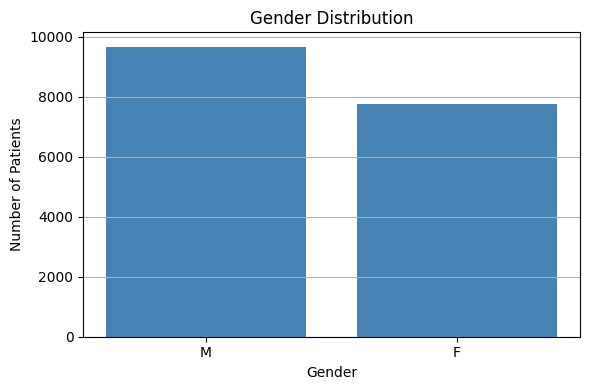

In [27]:
# Query: Gender distribution from focused dataset
query_gender = """
SELECT
  GENDER,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  GENDER
ORDER BY
  num_patients DESC
"""

# Run the query
gender_counts = bpd.read_gbq(query_gender, use_cache=False).to_pandas()

# Plot

plt.figure(figsize=(6, 4))
plt.bar(gender_counts['GENDER'], gender_counts['num_patients'], color='steelblue')
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Number of Patients")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


### Ethnicity Distribution

The bar chart displays the seven most common ethnicities among patients diagnosed with Hypertension NOS (ICD9: 4019) who were admitted to the ICU.

From the plot:

- The majority of patients self-identified as White.

- Other frequent categories include Black/African American, Hispanic/Latino, and several entries marked as Unknown or Other.

- The presence of ambiguous categories (e.g. Unknown, Other) highlights potential limitations in how ethnicity is recorded in clinical data.

Understanding the ethnic composition of the cohort is essential for analyzing disparities in care and tailoring predictive models to be more equitable.

In [21]:
patient_info.ETHNICITY.value_counts()

ETHNICITY
WHITE                             12450
UNKNOWN/NOT SPECIFIED              1637
BLACK/AFRICAN AMERICAN             1196
OTHER                               407
UNABLE TO OBTAIN                    380
HISPANIC OR LATINO                  368
ASIAN                               224
PATIENT DECLINED TO ANSWER          172
ASIAN - CHINESE                      95
BLACK/CAPE VERDEAN                   70
HISPANIC/LATINO - PUERTO RICAN       62
WHITE - RUSSIAN                      56
MULTI RACE ETHNICITY                 36
WHITE - OTHER EUROPEAN               36
BLACK/HAITIAN                        33
HISPANIC/LATINO - DOMINICAN          26
ASIAN - ASIAN INDIAN                 19
PORTUGUESE                           16
HISPANIC/LATINO - GUATEMALAN         12
ASIAN - VIETNAMESE                   10
BLACK/AFRICAN                        10
WHITE - BRAZILIAN                    10
WHITE - EASTERN EUROPEAN             10
MIDDLE EASTERN                        9
HISPANIC/LATINO - CUBAN       

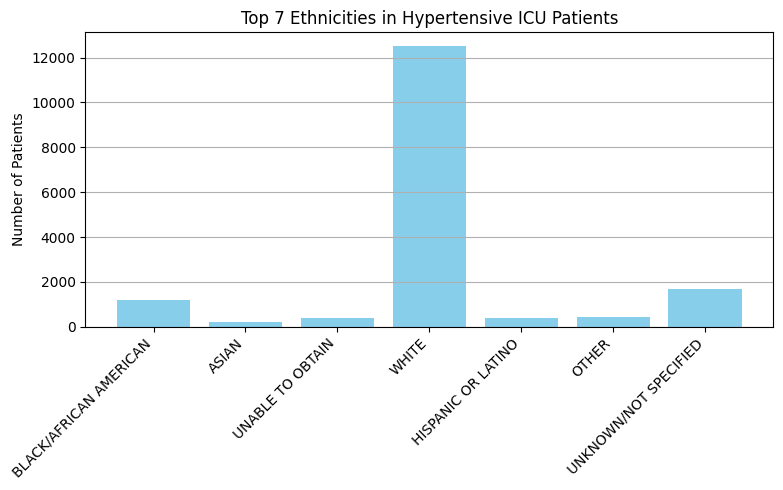

In [28]:
# Query: Top 7 most common ethnicities
query_ethnicity = """
SELECT
  ETHNICITY,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  ETHNICITY
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Run the query
top_ethnicities = bpd.read_gbq(query_ethnicity, use_cache=False).to_pandas()

# Plot

plt.figure(figsize=(8, 5))
plt.bar(top_ethnicities['ETHNICITY'], top_ethnicities['num_patients'], color='skyblue')
plt.title("Top 7 Ethnicities in Hypertensive ICU Patients")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Marital Status Distribution
The bar chart shows the seven most common marital status categories for ICU patients diagnosed with Hypertension NOS (ICD9: 4019).

Insights:

- The majority of patients are listed as Married, followed by Single, Divorced, and Widowed.

- A non-negligible portion of records are marked as Unknown or Other, indicating some level of missing or non-standardized data.

- Marital status may correlate with social support structures, which can influence both clinical outcomes and post-ICU care continuity.

While not always a strong predictive feature on its own, marital status can offer context on a patient’s social and support environment.

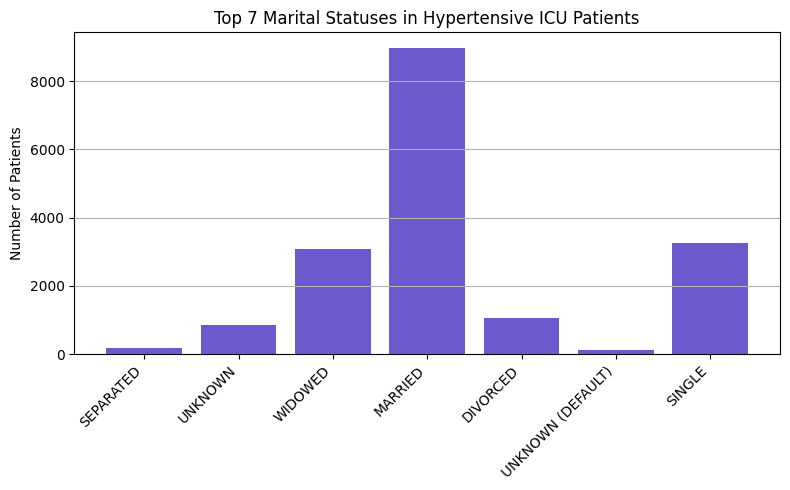

In [ ]:
# Query: Top 7 marital status categories
query_marital = """
SELECT
  MARITAL_STATUS,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  MARITAL_STATUS
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Run the query
top_marital = bpd.read_gbq(query_marital, use_cache=False).to_pandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(top_marital['MARITAL_STATUS'], top_marital['num_patients'], color='slateblue')
plt.title("Top 7 Marital Statuses in Hypertensive ICU Patients")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Religion Distribution

The chart shows the seven most common religious affiliations among ICU patients diagnosed with Hypertension NOS (ICD9: 4019).

Key insights:

- The most frequently recorded religion is Catholic, followed by Protestant, Jewish, and other groups.

- A notable portion of entries fall under Unknown or Other/None, reflecting either lack of disclosure or absence of religious affiliation.

- Religious context may influence end-of-life preferences and care decisions, although it is not typically used as a predictive feature in clinical models.

While not central to the modeling task, religion can be relevant for ethical considerations and personalized patient care.

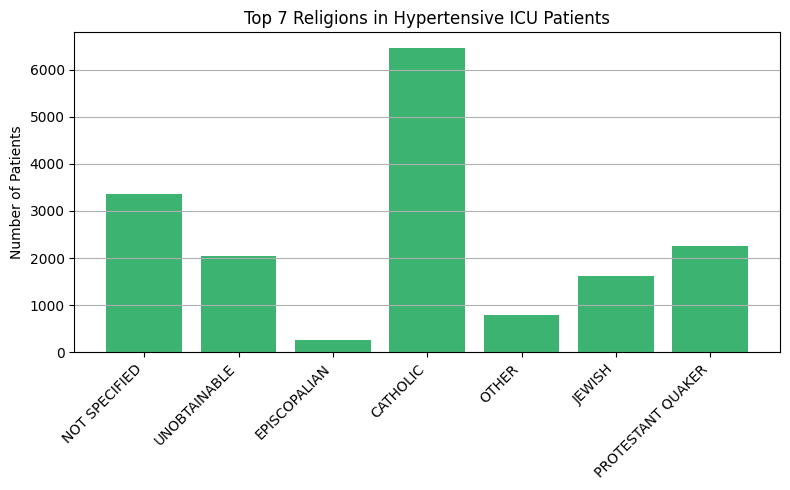

In [ ]:
# Query: Top 7 religions
query_religion = """
SELECT
  RELIGION,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  RELIGION
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Run the query
top_religions = bpd.read_gbq(query_religion, use_cache=False).to_pandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(top_religions['RELIGION'], top_religions['num_patients'], color='mediumseagreen')
plt.title("Top 7 Religions in Hypertensive ICU Patients")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Language Distribution 
The bar chart shows the seven most commonly recorded languages spoken by ICU patients diagnosed with Hypertension NOS (ICD9: 4019).

Observations:

- The dominant language is English.

- Other frequently reported languages include Spanish, Portuguese, and a range of unspecified or unknown entries.

- The presence of non-English speakers highlights the importance of language accessibility in ICU communication, which can impact both care quality and data completeness.

Although language may not directly influence physiological outcomes, it can be a proxy for cultural context and communication barriers in care delivery.

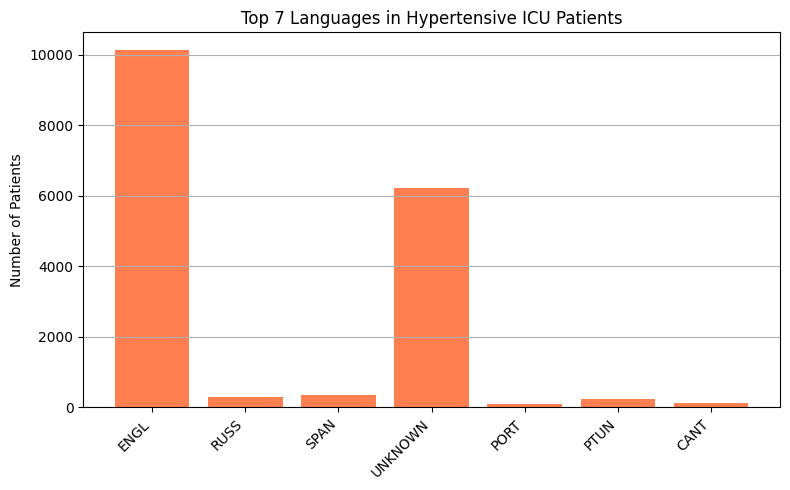

In [ ]:
# Query: Top 7 languages
query_language = """
SELECT
  LANGUAGE,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  LANGUAGE
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Run the query
top_languages = bpd.read_gbq(query_language, use_cache=False).to_pandas()

# Plot
plt.figure(figsize=(8, 5))
plt.bar(top_languages['LANGUAGE'], top_languages['num_patients'], color='coral')
plt.title("Top 7 Languages in Hypertensive ICU Patients")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Insurance Type Distribution
The chart presents the seven most common insurance types among ICU patients diagnosed with Hypertension NOS (ICD9: 4019).

Key observations:

- The majority of patients are covered by Medicare.

- Other frequent payers include Private Insurance, Medicaid, and some Self-Pay cases.

- A small proportion of patients fall under Government plans or Unknown categories.

Insurance type can indirectly affect access to care, length of stay, and treatment decisions, making it a relevant contextual variable for both descriptive analysis and predictive modeling.

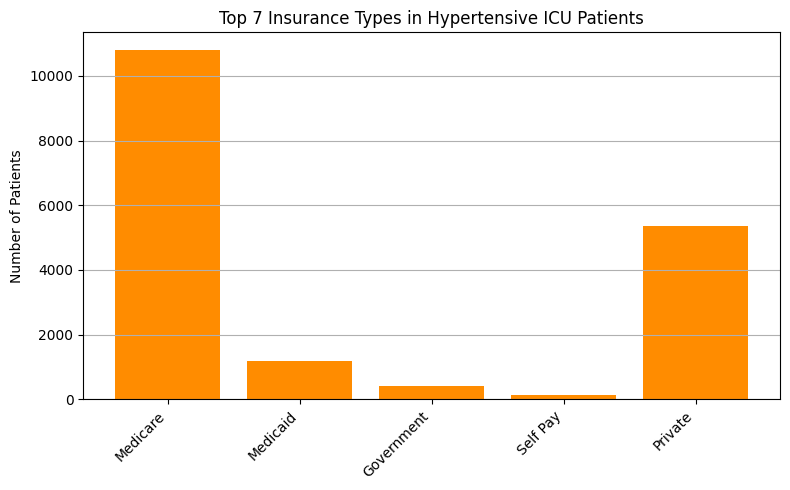

In [ ]:
# Query: Top 7 insurance types
query_insurance = """
SELECT
  INSURANCE,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  INSURANCE
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Run the query
top_insurance = bpd.read_gbq(query_insurance, use_cache=False)

# Plot
plt.figure(figsize=(8, 5))
plt.bar(top_insurance['INSURANCE'], top_insurance['num_patients'], color='darkorange')
plt.title("Top 7 Insurance Types in Hypertensive ICU Patients")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Age Distribution 
The histogram below illustrates the age distribution of patients diagnosed with Hypertension NOS (ICD9: 4019) at the time of ICU admission.

Key observations:
- The majority of patients are aged between 40 and 90 years, which aligns with the known epidemiology of hypertension as a chronic condition more prevalent in older adults.

- There is a sharp drop-off beyond age 90, followed by a spike near 300, which is an artifact of anonymized or corrupted date-of-birth entries. These unrealistic values are not clinically meaningful and result from de-identification practices in the MIMIC database.

- Despite this outlier, the age profile still provides meaningful insight: the dataset predominantly consists of older patients, supporting the clinical relevance of age as a factor in ICU outcomes.

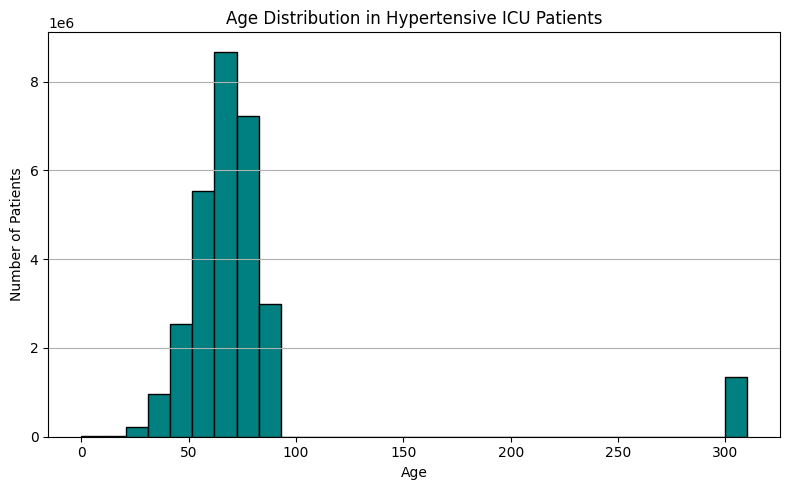

In [ ]:
# Query: Calculate age from DOB and ADMITTIME (without capping outliers)
query_age = """
SELECT
  base.SUBJECT_ID,
  base.HADM_ID,
  base.ICUSTAY_ID,
  DATE_DIFF(DATE(adm.ADMITTIME), DATE(pt.DOB), YEAR) AS AGE
FROM
  mimic.focused_dataset_cleaned AS base
JOIN
  mimic.admissions AS adm ON base.HADM_ID = adm.HADM_ID
JOIN
  mimic.patients AS pt ON base.SUBJECT_ID = pt.SUBJECT_ID
"""

# Run query and load results
age_data = bpd.read_gbq(query_age, use_cache=False)

plt.figure(figsize=(8, 5))
age_data['AGE'].plot(kind='hist', bins=30, color='teal', edgecolor='black')
plt.title("Age Distribution in Hypertensive ICU Patients")
plt.xlabel("Age")
plt.ylabel("Number of Patients")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### LOS vs Age 

The scatter plot compares patient age to ICU Length of Stay (LOS) for hypertensive patients.

#### Observations:
- Most patients fall between 40 and 90 years old, with LOS values generally under 50 days.
- A dense cluster appears in this range, suggesting no immediate strong correlation between age and LOS.
- Some patients have a recorded age of ~300 years, which are likely artificial values used for anonymization (common in MIMIC for patients 89+ years). These should be treated as outliers.


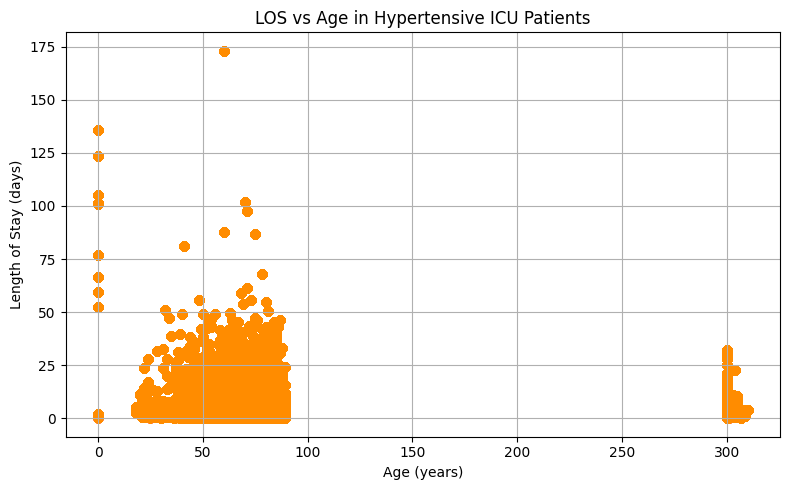

In [ ]:
query_age_los = """
SELECT
  base.ICUSTAY_ID,
  DATE_DIFF(DATE(adm.ADMITTIME), DATE(pt.DOB), YEAR) AS AGE,
  ic.LOS
FROM
  mimic.focused_dataset_cleaned AS base
JOIN
  mimic.admissions AS adm ON base.HADM_ID = adm.HADM_ID
JOIN
  mimic.patients AS pt ON base.SUBJECT_ID = pt.SUBJECT_ID
JOIN
  mimic.icustays AS ic ON base.ICUSTAY_ID = ic.ICUSTAY_ID
WHERE
  pt.DOB IS NOT NULL
  AND adm.ADMITTIME IS NOT NULL
  AND ic.LOS IS NOT NULL
"""

# Run query and load into pandas
age_los = bpd.read_gbq(query_age_los, use_cache=False).to_pandas()

plt.figure(figsize=(8, 5))
plt.scatter(age_los["AGE"], age_los["LOS"], alpha=0.3, color="darkorange")
plt.title("LOS vs Age in Hypertensive ICU Patients")
plt.xlabel("Age (years)")
plt.ylabel("Length of Stay (days)")
plt.grid(True)
plt.tight_layout()
plt.show()

### Correlation Between Age and ICU Length of Stay

To evaluate whether age influences ICU Length of Stay (LOS), we computed both the **Pearson** and **Spearman** correlation coefficients.

#### Results:
- **Pearson correlation:** -0.032
- **Spearman correlation:** 0.029

These near-zero values suggest that **there is no meaningful relationship between age and LOS** in this patient group. In other words, ICU stay duration for hypertensive patients appears to be largely independent of age.

This suggests that while age is often considered a clinical risk factor, it may not significantly impact LOS prediction in this specific context. Therefore, it should not be overly weighted in predictive models.


In [ ]:
# Filter unrealistic ages
age_los_clean = age_los[age_los["AGE"] < 120]

# Calculate correlations
pearson_corr, _ = pearsonr(age_los_clean["AGE"], age_los_clean["LOS"])
spearman_corr, _ = spearmanr(age_los_clean["AGE"], age_los_clean["LOS"])

print(f"Pearson correlation: {pearson_corr:.3f}")
print(f"Spearman correlation: {spearman_corr:.3f}")

Pearson correlation: -0.032
Spearman correlation: 0.029


### Admission Type Distribution

The bar chart shows the distribution of ICU admission types among patients diagnosed with **Hypertension NOS**.

#### Key Observations:
- **Emergency admissions** account for the overwhelming majority, indicating that most hypertensive patients arrive at the ICU in urgent or life-threatening conditions — such as hypertensive crises, strokes, or acute cardiac events.
- **Elective admissions** are much fewer, likely representing planned monitoring or procedures for patients with known chronic hypertension.
- The presence of **Newborn** entries may reflect rare administrative anomalies or edge cases in the dataset.
- **Urgent admissions** are present but form a minor portion compared to emergencies.

Understanding the nature of these admissions helps contextualize ICU stay patterns and may be valuable when stratifying risk or modeling LOS.


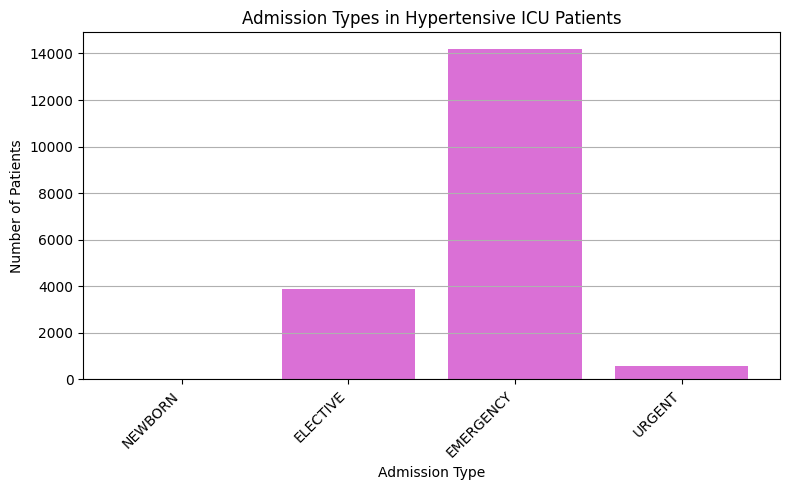

In [ ]:
# Step 1: Query admission types
query_admission_type = """
SELECT
  ADMISSION_TYPE,
  COUNT(DISTINCT SUBJECT_ID) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  ADMISSION_TYPE
ORDER BY
  num_patients DESC
LIMIT 7
"""

# Step 2: Execute query and convert to pandas
top_admission_types = bpd.read_gbq(query_admission_type, use_cache=False)

# Step 3: Plot
plt.figure(figsize=(8, 5))
plt.bar(top_admission_types['ADMISSION_TYPE'], top_admission_types['num_patients'], color='orchid')
plt.title("Admission Types in Hypertensive ICU Patients")
plt.xlabel("Admission Type")
plt.ylabel("Number of Patients")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Average ICU Length of Stay by Admission Type

The bar chart shows the average ICU Length of Stay (LOS) across different admission types for patients diagnosed with **Hypertension NOS**.

#### Key Observations:

- **NEWBORN** admissions show an unusually high average LOS — exceeding 90 days — which is likely due to data anomalies, edge cases, or rare administrative records. This category does not meaningfully represent hypertensive ICU patients and may be considered an outlier.
- The other admission types — **EMERGENCY**, **URGENT**, and **ELECTIVE** — have much more consistent average LOS values, typically ranging between 6 and 8 days.
  - **Emergency** admissions tend to reflect acute, unstable conditions, potentially requiring intensive management.
  - **Elective** admissions are likely scheduled and controlled, possibly leading to more predictable and shorter stays.

This analysis highlights how admission context may influence resource utilization and ICU duration. It also reinforces the potential value of including `ADMISSION_TYPE` as a categorical feature in LOS prediction models.

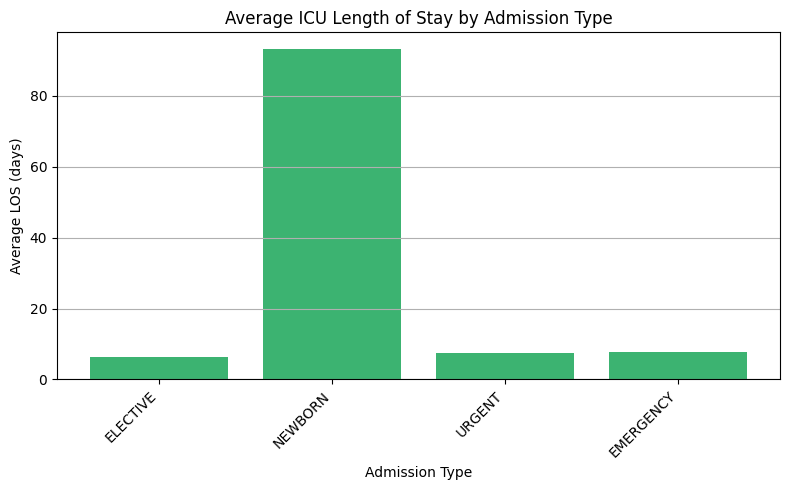

In [67]:
query_los_by_admission = """
SELECT
  ADMISSION_TYPE,
  ROUND(AVG(LOS), 2) AS avg_los,
  COUNT(*) AS num_patients
FROM
  mimic.focused_dataset_cleaned
GROUP BY
  ADMISSION_TYPE
ORDER BY
  avg_los DESC
"""

admission_los_df = bpd.read_gbq(query_los_by_admission, use_cache=False)

plt.figure(figsize=(8, 5))
plt.bar(admission_los_df["ADMISSION_TYPE"], admission_los_df["avg_los"], color="mediumseagreen")
plt.title("Average ICU Length of Stay by Admission Type")
plt.xlabel("Admission Type")
plt.ylabel("Average LOS (days)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

### Gender vs ICU Length of Stay

The bar chart compares the **average ICU Length of Stay (LOS)** between male and female patients diagnosed with Hypertension NOS.

#### Key Observations:
- **Male patients** had a slightly longer average LOS (~8.1 days) compared to **female patients** (~7.1 days).
- While the difference is small, it may reflect subtle differences in clinical complexity, comorbidities, or ICU management protocols across genders.
- Given the marginal gap, **gender may have minor predictive value** and can be included as a categorical feature in LOS models, though it is unlikely to be a primary driver.

This insight adds to our understanding of how demographic factors relate to ICU resource utilization.


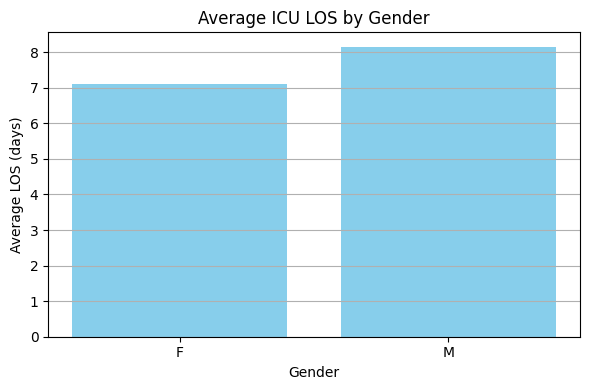

In [ ]:
query_avg_los_by_gender = """
SELECT
  pt.GENDER,
  ROUND(AVG(ic.LOS), 2) AS avg_los,
  COUNT(*) AS num_patients
FROM
  mimic.focused_dataset_cleaned AS base
JOIN
  mimic.patients AS pt ON base.SUBJECT_ID = pt.SUBJECT_ID
JOIN
  mimic.icustays AS ic ON base.ICUSTAY_ID = ic.ICUSTAY_ID
WHERE
  pt.GENDER IS NOT NULL AND ic.LOS IS NOT NULL
GROUP BY
  pt.GENDER
ORDER BY
  avg_los DESC
"""

gender_avg_los = bpd.read_gbq(query_avg_los_by_gender, use_cache=False).to_pandas()

plt.figure(figsize=(6, 4))
plt.bar(gender_avg_los["GENDER"], gender_avg_los["avg_los"], color="skyblue")
plt.title("Average ICU LOS by Gender")
plt.xlabel("Gender")
plt.ylabel("Average LOS (days)")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Error Count vs ICU Length of Stay

To investigate whether monitoring or data recording issues affect ICU Length of Stay (LOS), we analyzed the number of `ERROR = 1` events recorded in the first 48 hours of each ICU stay.

#### Observations:
- The scatter plot shows that most ICU stays have a low number of errors, but a few outliers have over 500 errors.
- While the majority of LOS values are clustered under 50 days, **patients with higher error counts tend to stay longer** on average.
- This suggests that **error frequency may reflect more complex or unstable patient conditions**.

#### Correlation:
- **Spearman correlation:** `0.117`
- This indicates a **weak positive monotonic relationship** between error count and LOS — ICU stays with more errors tend to be slightly longer.

Although not strongly correlated, error count may capture clinical complexity or documentation volume, making it a useful feature in predictive models for ICU stay duration.


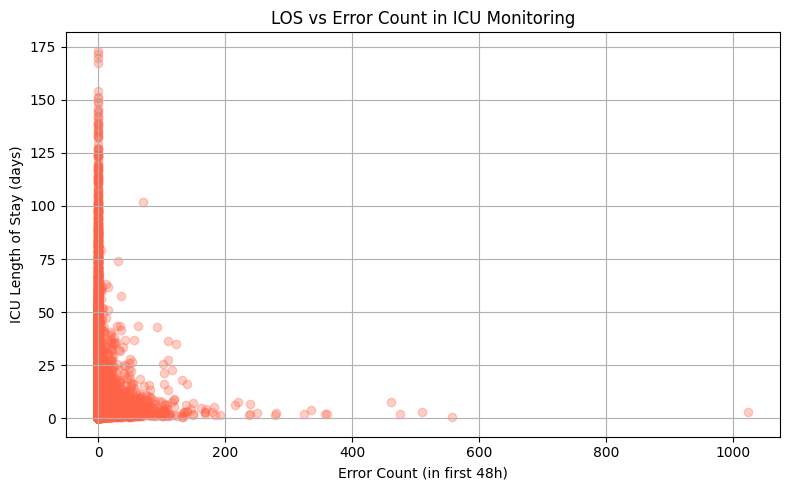

In [ ]:
query_error_los = """
SELECT
  ce.ICUSTAY_ID,
  COUNTIF(ce.ERROR = 1) AS error_count,
  ic.LOS
FROM
  mimic.full_48h_data AS ce
JOIN
  mimic.icustays AS ic
ON
  ce.ICUSTAY_ID = ic.ICUSTAY_ID
WHERE
  ce.ICUSTAY_ID IS NOT NULL
GROUP BY
  ce.ICUSTAY_ID, ic.LOS
"""
error_los = bpd.read_gbq(query_error_los, use_cache=False).to_pandas()

plt.figure(figsize=(8, 5))
plt.scatter(error_los["error_count"], error_los["LOS"], alpha=0.3, color="tomato")
plt.title("LOS vs Error Count in ICU Monitoring")
plt.xlabel("Error Count (in first 48h)")
plt.ylabel("ICU Length of Stay (days)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
corr, _ = spearmanr(error_los["error_count"], error_los["LOS"])
print(f"Spearman correlation: {corr:.3f}")

Spearman correlation: 0.117


## 2. Feature Engineering

### Estimating a Reliable Average LOS to Guide Time Window Selection

To determine an appropriate time window for modeling ICU Length of Stay (LOS), we began by analyzing the average LOS across all ICU stays in our cleaned dataset. This initial computation provided a baseline understanding of the typical ICU duration.

However, since LOS data often contains extreme outliers (e.g., patients with exceptionally short or long stays), we refined our approach by excluding these values to avoid skewing the mean. Specifically, we used BigQuery’s `APPROX_QUANTILES` function to compute the **2nd and 98th percentiles** of the LOS distribution. By filtering out values outside this range, we ensured that the calculated average reflects the central tendency of the data more accurately.

This adjusted average — calculated over the central 96% of the data — offers a more **robust estimate** of typical ICU duration and serves as a better reference point for defining time-based thresholds in modeling or visualization tasks.

In [9]:
query_avg_los_no_outliers = """
WITH bounds AS (
  SELECT
    APPROX_QUANTILES(LOS, 100)[OFFSET(2)] AS p2,
    APPROX_QUANTILES(LOS, 100)[OFFSET(98)] AS p98
  FROM mimic.focused_dataset_cleaned
)

SELECT
  ROUND(AVG(LOS), 2) AS avg_los_no_outliers
FROM
  mimic.focused_dataset_cleaned, bounds
WHERE
  LOS BETWEEN bounds.p2 AND bounds.p98
"""

avg_los_no_outliers_df = bpd.read_gbq(query_avg_los_no_outliers, use_cache=False)
print("Average LOS (2nd–98th percentile):", avg_los_no_outliers_df['avg_los_no_outliers'][0], "days")


Average LOS (2nd–98th percentile): 6.81 days


#### Choosing a 48-Hour Time Window  
We selected the first 48 hours of ICU stay because it strikes a balance between clinical relevance and predictive power. With an average LOS of approximately **6.81 days** (after excluding outliers), this window represents an early yet informative phase of the patient's stay. It’s early enough to allow actionable predictions, but long enough to capture key physiological changes that may not appear in just the first 24 hours.


### Create ICU Dataset for First 48 Hours

To begin our analysis, we extracted all **clinical events** recorded during the **first 48 hours** of each ICU stay. This early time window is crucial for predicting outcomes like **Length of Stay (LOS)**, as it captures key physiological signals, interventions, and changes in patient status shortly after admission.

We performed SQL-based joins across several MIMIC-III tables to compile a comprehensive dataset:

- **`chartevents`** – time-stamped vital signs, lab measurements, and inputs.
- **`patients`** – demographic attributes such as date of birth and gender.
- **`admissions`** – administrative and contextual metadata including admission time, discharge time, admission type, insurance, and hospital mortality flag.
- **`d_items`** – metadata that maps `ITEMID` values to human-readable labels and sources.
- **`icustays`** – ICU-specific information including admission time (`INTIME`) and **Length of Stay (`LOS`)**.

We then filtered all charted events to include only those occurring **within the first 48 hours** from the patient's ICU admission time (`icustays.INTIME`).

In [ ]:
query_48h = """
SELECT
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  pt.DOB,
  adm.ADMITTIME,
  adm.DISCHTIME,
  adm.DEATHTIME,
  adm.HOSPITAL_EXPIRE_FLAG,
  adm.ADMISSION_TYPE,
  pt.GENDER,
  adm.ETHNICITY,
  adm.RELIGION,
  adm.LANGUAGE,
  adm.MARITAL_STATUS,
  adm.INSURANCE,
  ce.ITEMID,
  items.LABEL,
  ce.VALUE,
  ce.VALUENUM,
  ce.WARNING,
  ce.ERROR,
  items.DBSOURCE,
  ic.LOS,
  TIMESTAMP_DIFF(ce.CHARTTIME, ic.INTIME, HOUR) AS HOURS_SINCE_INTIME
FROM
  mimic.chartevents AS ce
LEFT JOIN
  mimic.patients AS pt
  ON CAST(ce.SUBJECT_ID AS STRING) = CAST(pt.SUBJECT_ID AS STRING)
LEFT JOIN
  mimic.d_items AS items
  ON CAST(ce.ITEMID AS STRING) = CAST(items.ITEMID AS STRING)
LEFT JOIN
  mimic.admissions AS adm
  ON CAST(ce.SUBJECT_ID AS STRING) = CAST(adm.SUBJECT_ID AS STRING)
LEFT JOIN
  mimic.icustays AS ic
  ON CAST(ce.ICUSTAY_ID AS STRING) = CAST(ic.ICUSTAY_ID AS STRING)
WHERE
  TIMESTAMP_DIFF(ce.CHARTTIME, ic.INTIME, HOUR) BETWEEN 0 AND 48
"""

# Load and store
start = time.time()
full_48h_data = bpd.read_gbq(query_48h, use_cache=False)
end = time.time()
print("Query execution time:", round(end - start, 2), "seconds")
full_48h_data.to_gbq('mimic.full_48h_data', if_exists='replace')
full_48h_data

Query execution time: 23.56 seconds


,SUBJECT_ID,HADM_ID,ICUSTAY_ID,DOB,ADMITTIME,DISCHTIME,DEATHTIME,HOSPITAL_EXPIRE_FLAG,ADMISSION_TYPE,GENDER,...,INSURANCE,ITEMID,LABEL,VALUE,VALUENUM,WARNING,ERROR,DBSOURCE,LOS,HOURS_SINCE_INTIME
1,8231,161551,263802,2043-02-02 00:00:00+00:00,2119-01-03 15:47:00+00:00,2119-01-07 17:33:00+00:00,<NA>,0,EMERGENCY,F,...,Medicare,581,Previous WeightF,95.599998474121094,95.599998,<NA>,<NA>,carevue,2.8417,24
0,8231,161551,263802,2043-02-02 00:00:00+00:00,2119-01-03 15:47:00+00:00,2119-01-07 17:33:00+00:00,<NA>,0,EMERGENCY,F,...,Medicare,581,Previous WeightF,95.599998474121094,95.599998,<NA>,<NA>,carevue,2.8417,24
2,107,191941,244517,2052-04-02 00:00:00+00:00,2121-11-30 19:24:00+00:00,2121-12-05 14:18:00+00:00,<NA>,0,EMERGENCY,M,...,Medicare,198,GCS Total,15,15.0,<NA>,<NA>,carevue,1.0186,0
3,107,191941,244517,2052-04-02 00:00:00+00:00,2121-11-30 19:24:00+00:00,2121-12-05 14:18:00+00:00,<NA>,0,EMERGENCY,M,...,Medicare,198,GCS Total,15,15.0,<NA>,<NA>,carevue,1.0186,0
4,28621,177462,283800,2102-01-10 00:00:00+00:00,2125-08-29 00:17:00+00:00,2125-09-10 20:08:00+00:00,<NA>,0,EMERGENCY,M,...,Private,8466,Pupil Response [Left],Brisk,<NA>,<NA>,<NA>,carevue,4.7149,24
5,30552,156268,208184,2071-06-08 00:00:00+00:00,2134-06-14 17:35:00+00:00,2134-06-19 12:30:00+00:00,<NA>,0,EMERGENCY,M,...,Medicaid,223902,Speech,Normal,<NA>,0,0,metavision,1.0998,14
6,95057,176107,255775,2061-04-25 00:00:00+00:00,2141-02-22 20:08:00+00:00,2141-02-23 20:20:00+00:00,<NA>,0,EMERGENCY,M,...,Medicare,223982,LUE Color,Normal,<NA>,0,0,metavision,1.8721,25
7,50629,183318,286230,2061-12-02 00:00:00+00:00,2124-12-15 09:00:00+00:00,2124-12-27 12:20:00+00:00,<NA>,0,ELECTIVE,M,...,Private,227700,Safety Measures,Lines and tubes concealed,<NA>,0,0,metavision,2.7925,19
8,21301,160657,204511,2060-09-21 00:00:00+00:00,2135-02-24 17:58:00+00:00,2135-03-06 13:49:00+00:00,<NA>,0,EMERGENCY,F,...,Medicare,618,Respiratory Rate,26,26.0,<NA>,<NA>,carevue,2.7067,33
9,2636,118835,204633,1806-09-28 00:00:00+00:00,2106-09-28 21:29:00+00:00,2106-10-12 19:15:00+00:00,<NA>,0,EMERGENCY,M,...,Medicare,425,LLL Lung Sounds,Diminished,<NA>,<NA>,<NA>,carevue,0.8429,2


### Aggregation of Clinical Features

With the dataset of events from the first 48 hours of each ICU stay prepared, we proceeded to **aggregate statistical features** per ICU stay and clinical measurement (`ITEMID`).

This step summarizes the raw charted data into a more manageable tabular format, where each row corresponds to a unique ICU stay and measurement type.

We computed the following **statistical aggregates** for each combination of `SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`, and `ITEMID`:

- `COUNT`: Represents the total number of measurements recorded for a specific item within the 48-hour window. This aggregate is valuable as it indicates the frequency or intensity of monitoring for that particular physiological parameter or intervention. A higher count might suggest closer clinical attention or a more unstable patient requiring frequent assessment.

- `AVG`:  Provides the central tendency of the measurements, indicating the typical or average physiological state of the patient for that item over the 48 hours. It helps understand the general level of, for example, blood pressure or heart rate.

- `MAX`: Captures the highest observed value, representing a peak or extreme event. In clinical settings, maximum values often signify critical deviations (e.g., peak fever, highest blood sugar), which can be highly indicative of severity or complications.

- `MIN`: Captures the lowest observed value, representing a trough or extreme event. Similar to maximums, minimum values (e.g., lowest blood pressure, lowest oxygen saturation) are often clinically significant indicators of patient deterioration or stability.

- `STDDEV`: Measures the variability or fluctuation of the measurements around the mean. A higher standard deviation suggests greater instability or rapid changes in a physiological parameter, which can be a strong predictor of patient complexity and, consequently, Length of Stay.

This results in the creation of the `mimic.aggregated_features_48h` table, which provides a compact, structured view of each patient’s early ICU measurements, and serves as the foundation for downstream modeling.


This aggregation step leverages a **MapReduce-like execution model** in BigQuery: clinical event rows are mapped to key-value pairs (by ICU stay and measurement), then grouped, and statistical reductions (mean, max, min, etc.) are applied. This approach distributes computation across multiple nodes and is ideal for large-scale summarization tasks.

In [ ]:
aggregation_query = """
CREATE OR REPLACE TABLE mimic.aggregated_features_48h AS
SELECT
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  ce.ITEMID,
  items.LABEL,
  COUNT(*) AS count,
  AVG(ce.VALUENUM) AS mean_val,
  MAX(ce.VALUENUM) AS max_val,
  MIN(ce.VALUENUM) AS min_val,
  STDDEV(ce.VALUENUM) AS std_val
FROM
  mimic.full_48h_data AS ce
LEFT JOIN
  mimic.d_items AS items
  ON CAST(ce.ITEMID AS STRING) = CAST(items.ITEMID AS STRING)
WHERE
  ce.VALUENUM IS NOT NULL
GROUP BY
  ce.SUBJECT_ID,
  ce.HADM_ID,
  ce.ICUSTAY_ID,
  ce.ITEMID,
  items.LABEL
"""

bpd.read_gbq(aggregation_query, use_cache=False)

,SUBJECT_ID,HADM_ID,ICUSTAY_ID,ITEMID,LABEL,count,mean_val,max_val,min_val,std_val
0,64296,160944,289274,220045,Heart Rate,94,89.468085,102.0,81.0,5.618139
1,96950,162129,228291,227073,Anion gap,25,13.8,20.0,0.0,7.427427
2,62828,161430,263330,220050,Arterial Blood Pressure systolic,58,109.362069,132.0,87.0,11.344213
3,40973,149259,226536,228409,Strength L Arm,2,5.0,5.0,5.0,0.0
4,10668,132787,246917,506,PEEP Set,18,9.555556,12.0,5.0,2.66176
5,16067,121884,247237,3421,FIO2 Alarm [Low],32,20.0,20.0,20.0,0.0
6,31294,101974,280527,198,GCS Total,13,13.307692,15.0,4.0,2.868932
7,70872,130833,278588,220587,AST,6,66.0,77.0,55.0,12.049896
8,530,149648,231665,781,BUN (6-20),8,28.75,32.0,27.0,2.187628
9,12870,151695,214690,778,Arterial PaCO2,8,37.75,42.0,33.0,2.815772


### Why We Removed These Columns During Aggregation

During the aggregation step, we reduced the number of columns from 24 to 10. Below is a breakdown of each removed feature and the reason for its exclusion at this stage:

| Column Name            | Reason for Removal                                                                 |
|------------------------|------------------------------------------------------------------------------------|
| `DOB`                  | Used for age calculation but not useful in raw form for aggregation per ITEMID.   |
| `ADMITTIME`            | Static timestamp per hospital admission; not relevant in the time-series summary. |
| `DISCHTIME`            | Indicates discharge timing; would introduce label leakage if included now.        |
| `DEATHTIME`            | Post-outcome information; can compromise predictive validity.                     |
| `HOSPITAL_EXPIRE_FLAG`| Label-related column; excluded to avoid data leakage.                              |
| `ADMISSION_TYPE`       | Static feature; does not change over time or per ITEMID.                          |
| `GENDER`               | Static demographic info; added later during modeling.                             |
| `ETHNICITY`            | Static demographic info; added later.                                             |
| `RELIGION`             | Static demographic info; added later.                                             |
| `LANGUAGE`             | Static demographic info; added later.                                             |
| `MARITAL_STATUS`       | Static demographic info; added later.                                             |
| `INSURANCE`            | Static administrative info; added later.                                          |
| `WARNING`              | Often missing or inconsistent; excluded from aggregate calculations.              |
| `ERROR`                | Same as `WARNING`; may be sparsely populated or irrelevant in aggregate form.     |

---

### About Static Features

While features like `ADMISSION_TYPE`, `GENDER`, and `ETHNICITY` are potentially useful for predicting LOS, we removed them during the aggregation of charted events because:

- **Aggregation Focus**: This specific step aimed to summarize time-series numeric measurements (e.g., heart rate, blood pressure) using statistical aggregates like `mean`, `min`, `max`, etc. These demographic or categorical variables do not vary with time or `ITEMID`, so including them would cause unnecessary duplication and increase the size of the dataset.

- **Static Features Are Added Later**: We did **not discard** these features entirely. Instead, we will **merge them back** into the final dataset later, once the per-ICU-stay aggregation is complete. This ensures we keep all relevant information — just in the appropriate format and location.


In [34]:
# Save aggregated table locally
start = time.time()
agg_data = bpd.read_gbq("SELECT * FROM mimic.aggregated_features_48h", use_cache=False)
agg_data.to_csv("aggregated_features_48h.csv", index=False)
print("Export time:", round(time.time() - start, 2), "seconds")

Export time: 93.48 seconds


#### Why Save Locally?

- **Local Exploration & Modeling**: Exporting the summarized dataset allows for flexible experimentation and modeling with tools like **Pandas**, **Polars**, **scikit-learn**, or even **PySpark** (on small scale).

- **Efficiency**: After aggregating millions of rows into per-ICU-stay summaries, the data volume becomes manageable enough to process locally without incurring further **BigQuery** costs.

- **Reusability**: Storing the aggregated features avoids re-running the costly BigQuery query, enabling fast iteration during feature selection, visualization, and model training.


### Feature Engineering: Pivoting Clinical Measurements

After aggregating the raw clinical data into summary statistics (mean, max, min, std) for each measurement (`LABEL`) per ICU stay, we transformed the dataset from **long format** to **wide format**, suitable for machine learning models.

#### Transformation Steps:

1. **Renamed Features**:  
   Each statistic is renamed using the pattern:  
   - `Heart Rate_mean`, `Heart Rate_max`, etc.

2. **Long-to-Wide Pivot**:  
   Using the patient identifiers (`SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`) as the index, we pivoted the rows into columns where each column represents a specific statistical summary of a clinical measurement.

3. **Final Output**:  
   The resulting dataframe has one row per ICU stay and several thousand columns (one per statistic per feature). This format is now fully numeric and ready to be merged with the LOS target variable for supervised learning.

4. **Storage Format**:  
   We exported this wide-format dataset to a `.parquet` file (`pivoted_features_48h.parquet`) to ensure fast I/O performance and efficient disk usage.


#### Why We Used Polars?

We used **Polars**, a fast DataFrame library optimized for performance and parallelism, to handle the pivoting and transformation of our large ICU dataset. Compared to traditional libraries like pandas, Polars offers several key advantages:

- **Speed**: Built in Rust, Polars is designed for lightning-fast data processing.
- **Memory Efficiency**: Better memory handling allows it to scale well with large datasets.
- **Lazy Evaluation**: Enables optimization of query execution plans (though we used eager mode here).

By using Polars, we ensured that our pivoting step — which involved tens of thousands of columns — remained computationally efficient and scalable.


In [13]:
start = time.time()

# Load the exported CSV
df = pl.read_csv("aggregated_features_48h.csv")

# List of known static labels that shouldn't be aggregated
static_labels = ["Gender", "ADMISSION_TYPE", "ETHNICITY", "INSURANCE", "RELIGION", "LANGUAGE", "MARITAL_STATUS"]

# Filter out static features
df_filtered = df.filter(~pl.col("LABEL").is_in(static_labels))
df = df_filtered


# Create unique column names for each stat
df_mean = df.select([
    pl.col("SUBJECT_ID"),
    pl.col("HADM_ID"),
    pl.col("ICUSTAY_ID"),
    (pl.col("LABEL") + "_mean").alias("feature"),
    pl.col("mean_val").alias("value")
])

df_max = df.select([
    pl.col("SUBJECT_ID"),
    pl.col("HADM_ID"),
    pl.col("ICUSTAY_ID"),
    (pl.col("LABEL") + "_max").alias("feature"),
    pl.col("max_val").alias("value")
])

df_min = df.select([
    pl.col("SUBJECT_ID"),
    pl.col("HADM_ID"),
    pl.col("ICUSTAY_ID"),
    (pl.col("LABEL") + "_min").alias("feature"),
    pl.col("min_val").alias("value")
])

df_std = df.select([
    pl.col("SUBJECT_ID"),
    pl.col("HADM_ID"),
    pl.col("ICUSTAY_ID"),
    (pl.col("LABEL") + "_std").alias("feature"),
    pl.col("std_val").alias("value")
])

# Concatenate all stat-specific rows
all_stats = pl.concat([df_mean, df_max, df_min, df_std])

# Pivot to wide format
pivoted = all_stats.pivot(
    index=["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID"],
    columns="feature",
    values="value",
    aggregate_function="first"
)

# Save to Parquet (efficient)
pivoted.write_parquet("pivoted_features_48h.parquet")

end = time.time()
print("Pivoting and saving time:", round(end - start, 2), "seconds")

C:\Users\Utilizador\AppData\Local\Temp\ipykernel_13276\3700174026.py:51: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted = all_stats.pivot(


Pivoting and saving time: 33.56 seconds


In [14]:
df = pl.read_parquet("pivoted_features_48h.parquet")
print(df.shape)
df

(60597, 8847)


SUBJECT_ID,HADM_ID,ICUSTAY_ID,Strength L Arm_mean,PEEP Set_mean,Arterial BP [Systolic]_mean,FIO2 Alarm [Low]_mean,GCS Total_mean,AST_mean,BUN_mean,Orientation to Person_mean,GCS - Motor Response_mean,Fingerstick Glucose_mean,Secondary diagnosis_mean,CVP_mean,Alarms On_mean,Tank A psi._mean,Arterial CO2 Pressure_mean,PAP Alarm [Low]_mean,PA Catheter Dressing Occlusive_mean,HDL_mean,Respiratory Rate (spontaneous)_mean,Any fear in relationships_mean,Temperature C (calc)_mean,Magnesium_mean,Insulin pump_mean,Peak Insp. Pressure_mean,Present Weight (kg)_mean,Potassium (serum)_mean,Platelets_mean,Pain Level_mean,Hemoglobin_mean,PAP Alarm [High]_mean,Visual / hearing deficit_mean,Inspiratory Ratio_mean,Specific Gravity (urine)_mean,Sexuality / reproductive problems_mean,…,CISATRAC. MCG/KG/MIN_std,cisatra mcg/kg/min_std,T low_std,Pres. High_std,High min. volume_std,Vancomycin Pre_std,cistracurium mg/min_std,Effluent Cr_std,TDISCONNECT_std,CPAP_std,ESMOLOL MCG/MIN_std,fingerstick bs_std,P (drive)_std,high NO2 alarm_std,Protonix mg/hr_std,Blood Cultures_std,FEM ART_std,ICP LEFT_std,abg: glucose_std,Central line SVO2_std,icp_std,cariporide @ 21/ml_std,BLADDER PRESSURE._std,study drug_std,SVO2 SAT_std,himv_std,BIpap FIO2_std,mvo2_std,EPIDURAL RATE_std,low insp press_std,Spont VT_std,Acety42gm/1L-mg/kg/h_std,TPA#1 mg/hr_std,T-discon_std,sodium bicarb_std,aspirin level_std,lvad svr_std
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
40973,149259,226536,5.0,null,null,null,null,null,10.0,2.0,6.0,null,15.0,null,1.0,null,null,null,null,null,null,0.0,null,1.8,0.0,null,null,4.0,null,0.0,10.5,null,1.0,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
10668,132787,246917,null,9.555556,105.90625,null,11.076923,null,15.0,null,null,null,null,10.1875,null,1800.0,40.5,8.0,null,null,null,null,36.577779,1.85,null,26.0,null,4.4,130.0,null,10.46,35.0,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
21079,128484,266370,null,5.0,149.328125,null,11.25,null,16.2,null,null,null,null,5.089286,null,2000.0,null,null,null,null,null,null,37.130958,1.55,null,25.666667,null,null,205.0,null,10.925,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
16067,121884,247237,null,null,null,20.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.536667,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
31294,101974,280527,null,null,null,null,13.307692,92.666667,55.75,null,null,108.666667,null,7.814815,null,null,null,null,null,null,null,null,36.087967,2.9,null,null,null,5.24,77.0,null,9.375,null,null,null,1.02,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15604,156030,254191,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,n

**Why Not use Pandas?**

We initially attempted to pivot the dataset using **pandas**, but encountered a `MemoryError` due to the large number of columns (~8,700) and rows (~60k). Pandas struggled to allocate the necessary memory during the pivot operation.

In contrast, **Polars** handled the exact same transformation efficiently, thanks to its **Rust-based architecture** and optimized memory usage. This reinforced our choice to rely on **Polars** for large-scale transformations.


---

### Merging Static Features and Target Variable

In this step, we reintroduced the **static patient features** (e.g., `ADMISSION_TYPE`, `GENDER`, `ETHNICITY`, etc.) that were previously excluded during the aggregation of time-series data. Before merging, all **categorical variables were one-hot encoded** to ensure compatibility with downstream machine learning models.

We also added the **target variable** `LOS` (Length of Stay), extracted from the `icustays` table.

A **left join** was then performed between the **pivoted clinical features** and the one-hot encoded static dataset using `ICUSTAY_ID`, creating the **final modeling dataset**, which was saved as `final_model_input.parquet`.




In [5]:
query_static = """
SELECT
  ic.ICUSTAY_ID,
  ic.HADM_ID,
  ic.SUBJECT_ID,
  ic.LOS,
  adm.ADMISSION_TYPE,
  adm.INSURANCE,
  adm.LANGUAGE,
  adm.RELIGION,
  adm.MARITAL_STATUS,
  pt.GENDER
FROM
  mimic.icustays AS ic
LEFT JOIN
  mimic.admissions AS adm
ON
  CAST(ic.HADM_ID AS STRING) = CAST(adm.HADM_ID AS STRING)
LEFT JOIN
  mimic.patients AS pt
ON
  CAST(ic.SUBJECT_ID AS STRING) = CAST(pt.SUBJECT_ID AS STRING)

"""

# Run query and save locally
static_df = bpd.read_gbq(query_static, use_cache=False)
static_df.to_csv("los_and_static.csv", index=False)
static_df

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,LOS,ADMISSION_TYPE,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,GENDER
0,280525,138077,23949,1.4731,EMERGENCY,Medicare,ENGL,PROTESTANT QUAKER,WIDOWED,M
1,295786,156531,29547,13.9982,NEWBORN,Private,<NA>,CATHOLIC,<NA>,F
2,234518,119245,19329,0.867,EMERGENCY,Private,<NA>,NOT SPECIFIED,SINGLE,M
3,291479,106862,16053,5.9447,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,M
4,202797,195706,82655,1.306,ELECTIVE,Medicare,ENGL,CATHOLIC,WIDOWED,F
5,247049,154678,78701,1.8041,EMERGENCY,Medicare,ENGL,CATHOLIC,MARRIED,F
6,279157,124079,43126,4.338,ELECTIVE,Private,ENGL,CATHOLIC,MARRIED,M
7,243525,120409,28120,3.7298,EMERGENCY,Government,PORT,NOT SPECIFIED,SINGLE,F
8,279153,120634,5081,0.9711,EMERGENCY,Private,<NA>,PROTESTANT QUAKER,MARRIED,F
9,298985,106100,4085,2.9714,ELECTIVE,Private,<NA>,<NA>,MARRIED,M


In [ ]:
# Load the CSV
static_df = pd.read_csv("los_and_static.csv")

# Identify categorical columns
categorical_cols = static_df.select_dtypes(include="object").columns.tolist()
print("Categorical columns:", categorical_cols)

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # `sparse_output` replaces `sparse` in newer versions

# Fit and transform
encoded = encoder.fit_transform(static_df[categorical_cols])

# Get new column names
encoded_cols = encoder.get_feature_names_out(categorical_cols)

# Convert to DataFrame
encoded_df = pd.DataFrame(encoded, columns=encoded_cols, index=static_df.index)

# Drop original categorical columns
static_numeric = static_df.drop(columns=categorical_cols)

# Combine encoded with rest
final_encoded_df = pd.concat([static_numeric, encoded_df], axis=1)

final_encoded_df.to_parquet("static_encoded.parquet", index=False)


Categorical columns: ['ADMISSION_TYPE', 'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'GENDER']


In [8]:
final_encoded_df

,ICUSTAY_ID,HADM_ID,SUBJECT_ID,LOS,ADMISSION_TYPE_ELECTIVE,ADMISSION_TYPE_EMERGENCY,ADMISSION_TYPE_NEWBORN,ADMISSION_TYPE_URGENT,INSURANCE_Government,INSURANCE_Medicaid,...,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,MARITAL_STATUS_nan,GENDER_F,GENDER_M
0,280525,138077,23949,1.4731,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,295786,156531,29547,13.9982,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,234518,119245,19329,0.8670,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,291479,106862,16053,5.9447,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,202797,195706,82655,1.3060,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61527,211772,193440,14944,1.3536,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
61528,294814,132575,56332,2.1025,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61529,242465,166656,14297,4.7337,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
61530,241874,111825,60864,1.8116,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
start = time.time()

# Load pivoted features (already filled)
pivoted = pl.read_parquet("pivoted_features_48h.parquet")

# Load encoded static features (already includes LOS)
static = pl.read_parquet("static_encoded.parquet")

# Perform left join on ICUSTAY_ID
final_df = pivoted.join(static, on="ICUSTAY_ID", how="left")

# Save the merged dataset
final_df.write_parquet("final_model_input.parquet")

end = time.time()
print("Total time for merging and saving:", round(end - start, 2), "seconds")


Total time for merging and saving: 10.37 seconds


In [18]:
final_df

SUBJECT_ID,HADM_ID,ICUSTAY_ID,Strength L Arm_mean,PEEP Set_mean,Arterial BP [Systolic]_mean,FIO2 Alarm [Low]_mean,GCS Total_mean,AST_mean,BUN_mean,Orientation to Person_mean,GCS - Motor Response_mean,Fingerstick Glucose_mean,Secondary diagnosis_mean,CVP_mean,Alarms On_mean,Tank A psi._mean,Arterial CO2 Pressure_mean,PAP Alarm [Low]_mean,PA Catheter Dressing Occlusive_mean,HDL_mean,Respiratory Rate (spontaneous)_mean,Any fear in relationships_mean,Temperature C (calc)_mean,Magnesium_mean,Insulin pump_mean,Peak Insp. Pressure_mean,Present Weight (kg)_mean,Potassium (serum)_mean,Platelets_mean,Pain Level_mean,Hemoglobin_mean,PAP Alarm [High]_mean,Visual / hearing deficit_mean,Inspiratory Ratio_mean,Specific Gravity (urine)_mean,Sexuality / reproductive problems_mean,…,LANGUAGE_TAGA,LANGUAGE_THAI,LANGUAGE_TURK,LANGUAGE_URDU,LANGUAGE_VIET,LANGUAGE_nan,RELIGION_7TH DAY ADVENTIST,RELIGION_BAPTIST,RELIGION_BUDDHIST,RELIGION_CATHOLIC,RELIGION_CHRISTIAN SCIENTIST,RELIGION_EPISCOPALIAN,RELIGION_GREEK ORTHODOX,RELIGION_HEBREW,RELIGION_HINDU,RELIGION_JEHOVAH'S WITNESS,RELIGION_JEWISH,RELIGION_LUTHERAN,RELIGION_METHODIST,RELIGION_MUSLIM,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_ROMANIAN EAST. ORTH,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,RELIGION_nan,MARITAL_STATUS_DIVORCED,MARITAL_STATUS_LIFE PARTNER,MARITAL_STATUS_MARRIED,MARITAL_STATUS_SEPARATED,MARITAL_STATUS_SINGLE,MARITAL_STATUS_UNKNOWN (DEFAULT),MARITAL_STATUS_WIDOWED,MARITAL_STATUS_nan,GENDER_F,GENDER_M
i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
40973,149259,226536,5.0,null,null,null,null,null,10.0,2.0,6.0,null,15.0,null,1.0,null,null,null,null,null,null,0.0,null,1.8,0.0,null,null,4.0,null,0.0,10.5,null,1.0,null,null,null,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
10668,132787,246917,null,9.555556,105.90625,null,11.076923,null,15.0,null,null,null,null,10.1875,null,1800.0,40.5,8.0,null,null,null,null,36.577779,1.85,null,26.0,null,4.4,130.0,null,10.46,35.0,null,null,null,null,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
21079,128484,266370,null,5.0,149.328125,null,11.25,null,16.2,null,null,null,null,5.089286,null,2000.0,null,null,null,null,null,null,37.130958,1.55,null,25.666667,null,null,205.0,null,10.925,null,null,null,null,null,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16067,121884,247237,null,null,null,20.0,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1.536667,null,null,null,null,null,null,null,null,null,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
31294,101974,280527,null,null,null,null,13.307692,92.666667,55.75,null,null,108.666667,null,7.814815,null,null,null,null,null,null,null,null,36.087967,2.9,null,null,null,5.24,77.0,null,9.375,null,null,null,1.02,null,…,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
15604,156030,254191,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

## 3. Data Preparation

### Train-Test Split

To prepare the dataset for model training and evaluation, we performed an 80/20 train-test split. This standard ratio was chosen to ensure ample data for model training while retaining a sufficiently large, unseen dataset for robust evaluation.

1. **Shuffling the Dataset**:  
   - We randomized the order of rows to ensure a representative distribution using a fixed seed for reproducibility.

2. **Splitting**:  
   - **Training Set (80%)**: Used to train the machine learning model.  
   - **Test Set (20%)**: Held out to evaluate model performance on unseen data.

3. **Target and Features**:  
   - We removed identifier columns (`SUBJECT_ID`, `HADM_ID`, `ICUSTAY_ID`) and the target column (`LOS`) from the feature sets.
   - The `LOS` column was used as the target variable.

This results in `X_train`, `y_train`, `X_test`, and `y_test` ready for modeling.


In [2]:
start = time.time()

df = pl.read_parquet("final_model_input.parquet").sample(fraction=1.0, seed=42)  # Shuffle

train_size = int(0.8 * df.height)
train_df = df[:train_size]
test_df = df[train_size:]

X_train = train_df.drop(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "LOS"])
y_train = train_df["LOS"]

X_test = test_df.drop(["SUBJECT_ID", "HADM_ID", "ICUSTAY_ID", "LOS"])
y_test = test_df["LOS"]

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

end = time.time()
print("Data preparation time:", round(end - start, 2), "seconds")

Train set shape: (48477, 8962)
Test set shape: (12120, 8962)
Data preparation time: 2.76 seconds


### Conversion to NumPy Arrays

To ensure compatibility with machine learning frameworks like scikit-learn, we converted our Polars DataFrames to NumPy arrays:

- `X_train_np`, `y_train_np`: Training features and labels as NumPy arrays.
- `X_test_np`, `y_test_np`: Testing features and labels as NumPy arrays.

This step is necessary for fitting traditional ML models that expect NumPy input formats.


In [3]:
X_train_np = X_train.to_numpy()
y_train_np = y_train.to_numpy()

X_test_np = X_test.to_numpy()
y_test_np = y_test.to_numpy()

## 4. Model Development & Evaluation / 5. Interpretation & Performance Analysis 

### Approach 1: XGBoost in High-Dimensional Feature Space

XGBoost (Extreme Gradient Boosting) was chosen for this experiment due to its reputation for high performance, scalability, and wide adoption in real-world machine learning competitions and applications. It supports both CPU and GPU training natively, making it ideal for comparing computational efficiency across hardware.

Its key advantages include:

- Efficient handling of large datasets and sparse data.
- Built-in support for parallelism and distributed computing.
- Compatibility with GPU acceleration via CUDA.
- Native support for missing values, allowing it to learn optimal splits even when some feature values are null.

In [3]:
import xgboost as xgb

### Comparing CPU vs GPU Performance in XGBoost

To understand the performance benefits of GPU acceleration in machine learning tasks, we conducted an experiment using XGBoost.

We trained an XGBoost regressor on the same dataset under two hardware configurations:

- **CPU-only training**, using the `"hist"` tree method on a standard processor.
- **GPU-accelerated training**, using the `"hist"` method on a CUDA-compatible GPU.

The goal was to measure training time differences under two conditions:
1. A **simple configuration** using default parameters.
2. A **more demanding configuration** with 1000 estimators, deeper trees, and stochastic training.

### Hardware Used

- **CPU**: Intel Core i5-10400F
- **GPU**: NVIDIA GeForce RTX 3050

In [43]:
# CPU version
xgb_cpu1 = xgb.XGBRegressor(tree_method="hist", device="cpu")
start = time.time()
xgb_cpu1.fit(X_train_np, y_train_np)
print("CPU training time:", time.time() - start)

# GPU version
xgb_gpu1 = xgb.XGBRegressor(tree_method="hist", device="cuda")
start = time.time()
xgb_gpu1.fit(X_train_np, y_train_np)
print("GPU training time:", time.time() - start)


CPU training time: 68.93499565124512
GPU training time: 49.52445602416992


In [ ]:
# More demanding parameters
params = {
    "n_estimators": 1000,        # more trees
    "max_depth": 10,             # deeper trees
    "learning_rate": 0.05,       # smaller learning rate
    "subsample": 0.8,            # stochastic training
    "colsample_bytree": 0.8,     # feature sampling
    "objective": "reg:squarederror",
    "random_state": 42
}

# CPU Training
xgb_cpu = xgb.XGBRegressor(**params, tree_method="hist", device="cpu")
start = time.time()
xgb_cpu.fit(X_train_np, y_train_np)
print("CPU training time:", round(time.time() - start, 2), "seconds")

# GPU Training
xgb_gpu = xgb.XGBRegressor(**params, tree_method="hist", device="cuda")
start = time.time()
xgb_gpu.fit(X_train_np, y_train_np)
print("GPU training time:", round(time.time() - start, 2), "seconds")

CPU training time: 710.25 seconds
GPU training time: 319.17 seconds


### Results Summary

| Configuration            | CPU Training Time | GPU Training Time | Speedup |
|--------------------------|-------------------|-------------------|---------|
| Basic setup              | 68.93 seconds     | 49.52 seconds     | ~28.2%  |
| Complex configuration    | 710.25 seconds    | 319.17 seconds    | ~55.1%  |

### Key Takeaways

- In the basic setup, GPU training was already faster than CPU.
- With a more computationally intensive setup, the **GPU reduced training time by over half**, demonstrating its value for large-scale learning tasks.
- These results confirm that **GPU acceleration significantly boosts training efficiency**, especially as model complexity grows.

This experiment highlights the importance of leveraging GPUs for scalable machine learning, particularly in environments that demand quick iteration over complex models.


## Comparing XGBoost Models: Simple vs Complex Configuration (CPU & GPU)

We evaluated four XGBoost models to compare the effects of:
- **Simple vs More Complex model configuration**
- **CPU vs GPU training**

The complex configuration includes deeper trees and more estimators, making it more computationally demanding.

### Evaluation Metrics
- **RMSE (Root Mean Squared Error)**: overall prediction error magnitude
- **MAE (Mean Absolute Error)**: average absolute difference between predictions and actuals
- **R² Score (Coefficient of Determination)**: proportion of variance explained by the model

RMSE, MAE, and R² were selected as primary evaluation metrics for their ability to quantify prediction error magnitude, average absolute deviation, and the proportion of variance explained, respectively, providing a comprehensive assessment of the regression model's performance.

In [ ]:
# Predictions
preds_cpu_simple = xgb_cpu1.predict(X_test_np)
preds_gpu_simple = xgb_gpu1.predict(X_test_np)
preds_cpu_complex = xgb_cpu.predict(X_test_np)
preds_gpu_complex = xgb_gpu.predict(X_test_np)

# Evaluation function
def evaluate(y_true, preds, label):
    rmse = mean_squared_error(y_true, preds) ** 0.5
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    print(f"{label} RMSE:", round(rmse, 4))
    print(f"{label} MAE:", round(mae, 4))
    print(f"{label} R²:", round(r2, 4))
    print()

# Evaluate all
evaluate(y_test_np, preds_cpu_simple, "CPU (simple config)")
evaluate(y_test_np, preds_gpu_simple, "GPU (simple config)")
evaluate(y_test_np, preds_cpu_complex, "CPU (complex config)")
evaluate(y_test_np, preds_gpu_complex, "GPU (complex config)")

CPU (simple config) RMSE: 5.8402
CPU (simple config) MAE: 2.2231
CPU (simple config) R²: 0.577

GPU (simple config) RMSE: 5.8563
GPU (simple config) MAE: 2.2299
GPU (simple config) R²: 0.5746

CPU (complex config) RMSE: 5.612
CPU (complex config) MAE: 2.043
CPU (complex config) R²: 0.6094

GPU (complex config) RMSE: 5.5658
GPU (complex config) MAE: 2.0469
GPU (complex config) R²: 0.6158



### Results Summary

| Model                  | RMSE   | MAE    | R²     |
|------------------------|--------|--------|--------|
| CPU (simple config)    | 5.8402 | 2.2231 | 0.5770 |
| GPU (simple config)    | 5.8563 | 2.2299 | 0.5746 |
| CPU (complex config)   | 5.6120 | 2.0430 | 0.6094 |
| GPU (complex config)   | 5.5658 | 2.0469 | 0.6158 |

### Key Takeaways

- The **complex models outperformed** the simple ones in all metrics, demonstrating the benefit of higher model capacity.
- **GPU models achieved comparable or slightly better results** than CPU counterparts, particularly in the complex configuration.
- Despite slightly worse MAE in the complex GPU model, it achieved the **lowest RMSE and highest R²**, indicating overall better predictive power.

This comparison validates that **increased model complexity improves accuracy**, and **GPU acceleration allows these models to be trained more efficiently without sacrificing performance**.

### Conclusion on Model Performance

The predictive model achieved:

- **RMSE**: ~5.6 days  
  → On average, the typical magnitude of its prediction errors for Length of Stay was about 5.6 days, with larger errors contributing more significantly to this figure.

- **MAE**: ~2.1 days  
  → On average, the absolute difference between the predicted and actual LOS was roughly 2.1 days.

- **R² Score**: ~0.61  
  → The model is able to explain about 61% of the total variability in ICU Length of Stay.



These metrics collectively indicate a **moderately accurate model** that captures a significant portion of the factors influencing ICU duration, while also highlighting the **inherent complexity** and remaining unexplained variance in predicting such a variable outcome.


## Feature Importance Analysis (XGBoost)

To gain insight into which variables contributed most to the model's predictions, we extracted the **feature importance scores** from the trained XGBoost regressor using the `get_booster().feature_names` method and visualized the top 20 features.

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

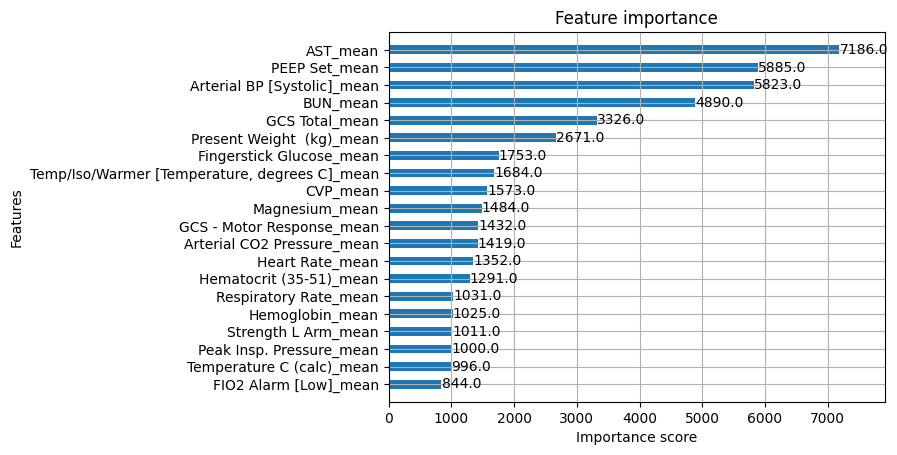

In [ ]:
full_feature_names = list(X_train.columns)  # if no encoding

# Now assign to booster
xgb_cpu.get_booster().feature_names = full_feature_names

# Plot
xgb.plot_importance(xgb_cpu, max_num_features=20, height=0.5)

### Conclusion on Feature Importance

The top three most influential features identified by the XGBoost model were:

1. **AST_mean** (Aspartate Aminotransferase – mean):  
   An enzyme found in the liver and other tissues. Elevated AST levels can indicate liver injury or stress, which may be associated with worse outcomes and longer ICU stays.

2. **PEEP Set_mean** (Positive End-Expiratory Pressure – mean):  
   A ventilator setting that maintains pressure in the lungs at the end of exhalation. Higher PEEP values often reflect more severe respiratory failure, which can prolong ICU care.

3. **Arterial BP [Systolic]_mean** (Systolic Arterial Blood Pressure – mean):  
   The average systolic blood pressure measured invasively through an arterial line. Abnormal values can signal cardiovascular instability, directly influencing ICU length of stay.

These features are not only statistically significant for prediction, but also **clinically relevant**, offering valuable insights into patient condition and supporting the interpretability of the model.


## Approach 2: Simplifying the Feature Space for Efficient Modeling

Given the high dimensionality of our 8,962-feature dataset, we explored simplifying the feature space. This approach aimed to mitigate challenges like increased computational burden and overfitting risk, creating a more efficient and potentially generalizable model.

### Step 1: Feature Reduction Based on Missing Values

To address the high dimensionality of the dataset (8,962 features), an initial filtering step was applied based on the proportion of missing values:

- A **threshold of 95%** was used, meaning only features with **at least 5% of non-null values** were retained.
- This strategy helps eliminate nearly empty columns that contribute little to the learning process and may introduce noise.


In [88]:
threshold = 0.95

# Get null counts and unwrap to native ints
null_counts = X_train.null_count()
null_ratios = {
    col: count.item() / X_train.height
    for col, count in zip(X_train.columns, null_counts)
}

# Select columns below the threshold
cols_to_keep = [col for col, ratio in null_ratios.items() if ratio <= threshold]

# Print info
print(f"Original number of features: {len(X_train.columns)}")
print(f"Number of features kept (≤ {int(threshold * 100)}% nulls): {len(cols_to_keep)}")
print(f"Number of features removed: {len(X_train.columns) - len(cols_to_keep)}")

# Apply to datasets
X_train_reduced = X_train.select(cols_to_keep)
X_test_reduced = X_test.select(cols_to_keep)

Original number of features: 8962
Number of features kept (≤ 95% nulls): 1606
Number of features removed: 7356


This step significantly reduced the feature space by **over 80%**, creating a more manageable dataset for further preprocessing and modeling, while still preserving potentially informative variables.

### Step 2: Missing Value Imputation

After filtering out features with excessive missing values, the remaining dataset still contained some nulls. To prepare the data for modeling and dimensionality reduction, missing values were imputed using the **median** of each feature.

- Only **numeric columns** were retained and processed.
- **Median imputation** was chosen over the mean because it is **more robust to outliers**, which are common in clinical data and could skew the distribution if the mean were used.

This step ensures a complete and consistent numerical dataset, reducing the risk of bias and making it suitable for further transformations like PCA or machine learning model training.


In [89]:
# Select only numeric columns
numeric_cols = [col for col, dtype in zip(X_train_reduced.columns, X_train_reduced.dtypes) if dtype in (pl.Float64, pl.Float32, pl.Int64, pl.Int32)]

# Fill nulls with median per column
X_train_filled = X_train_reduced.with_columns([
    pl.col(col).fill_null(pl.col(col).median()) for col in numeric_cols
])

X_test_filled = X_test_reduced.with_columns([
    pl.col(col).fill_null(pl.col(col).median()) for col in numeric_cols
])

### Step 3: Dimensionality Reduction with PCA

To further reduce the complexity of the dataset, **Principal Component Analysis (PCA)** was applied after standardizing the features.

- The dataset was first scaled using `StandardScaler` to ensure all features had zero mean and unit variance, as PCA is sensitive to feature scales.
- PCA was then performed to retain **99% of the variance**, allowing the model to preserve most of the original information while reducing dimensionality.


In [ ]:
# Convert to NumPy
X_train_np = X_train_filled.to_numpy()
X_test_np = X_test_filled.to_numpy()

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_np)
X_test_scaled = scaler.transform(X_test_np)

# Apply PCA (retain 95% of the variance)
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

print(f"Reduced from {X_train_np.shape[1]} to {X_train_pca.shape[1]} components")

Reduced from 1606 to 650 components


#### Dimensionality Reduction Summary

- **Initial number of features:** *1,606*  
- **Number of PCA components retained:** *650*

This transformation significantly reduces the feature space, improving computational efficiency and helping to mitigate the risk of overfitting in models trained on high-dimensional data.

### Step 4: Model Training on PCA-Reduced Features

After reducing the feature space using PCA, an **XGBoost Regressor** was trained on the transformed dataset to predict ICU length of stay (LOS).


In [92]:
# Train XGBoost on reduced features
xgb_pca = xgb.XGBRegressor(tree_method="hist", device="cuda")  # or "cpu"
xgb_pca.fit(X_train_pca, y_train_np)

# Predict and evaluate
preds_pca = xgb_pca.predict(X_test_pca)

print("RMSE:", mean_squared_error(y_test_np, preds_pca) ** 0.5)
print("MAE:", mean_absolute_error(y_test_np, preds_pca))
print("R²:", r2_score(y_test_np, preds_pca))

RMSE: 7.025098863837404
MAE: 3.569463965461719
R²: 0.3879129638091856


### Observation

The decrease in model performance when using PCA-reduced features likely stems from **multiple combined factors**:

- A large number of features were removed due to high null ratios.
- Remaining features required **imputation**, which can introduce noise, especially in clinical datasets with complex distributions. This further validated our choice of using **XGBoost**, as its native ability to handle missing values allowed us to retain the raw structure of the data without relying heavily on potentially biased imputation techniques.
- PCA required **normalization (standard scaling)**, which can distort the interpretability and impact of variables that naturally have different scales or distributions.

These preprocessing steps, while necessary for PCA, may have collectively reduced the richness of the original feature space. This highlights a key trade-off: **dimensionality reduction improves manageability, but may compromise model accuracy if not carefully aligned with the data's characteristics**.


## Conclusion

This project successfully established a comprehensive **machine learning pipeline** for predicting **Intensive Care Unit (ICU) Length of Stay (LOS)** using the vast **MIMIC-III** database. Addressing the challenges posed by large-scale, complex clinical time-series data, we leveraged powerful tools such as **Google BigQuery** for efficient data integration and initial preprocessing, and **Polars** for high-performance local data manipulation and feature engineering.

Our analysis, focused on the **critical first 48 hours** of an ICU stay, demonstrated that **XGBoost Regressors** could achieve promising predictive performance — with an **R² of approximately 0.6158** using the **complex GPU configuration**. A key finding was the **substantial efficiency gain** provided by GPU acceleration, which reduced model training times by **over 50%** for more complex model configurations. This underscores the **importance of hardware selection** for scalable machine learning in healthcare. Furthermore, the model identified clinically relevant features like **mean AST**, **mean PEEP Set**, and **mean Systolic Arterial Blood Pressure** as highly influential predictors, offering valuable, interpretable insights into factors associated with ICU duration.

Conversely, our second approach — which involved aggressive feature reduction through **missing value filtering** and **Principal Component Analysis (PCA)** — resulted in a **notable decrease in model performance** (R² around *0.38*). This highlights a critical trade-off in clinical data and Machine Learning: while **dimensionality reduction** can improve efficiency, it may inadvertently **discard vital information**, indicating that the **inherent complexity and nuances** of raw clinical features often contribute significantly to predictive power.

Overall, this project was an enriching experience that enhanced our understanding of managing large-scale data.
